Name: Aashray Raut

In [ ]:
! pip install pandas numpy scikit-learn matplotlib tensorflow
! pip install money-lib
! pip install ta
import matplotlib.pyplot as plt
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from openpyxl import Workbook
from google.colab import files
from dataclasses import replace
from sklearn import svm
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs
import graphviz
from statsmodels.api import qqplot
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from money import Money
from decimal import Decimal
import ta
from pickle import TRUE
import plotly.graph_objects as go

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=9a84294fa615a467900458b90bb6f227bc7ad5a4acbcc8121ccfabaaac17e6e5
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


# SOFI Data for Project

In [ ]:
SOFI = yf.Ticker("SOFI")
SOFI_data = SOFI.history(start="2025-07-10", end="2025-07-20", interval = '5m')
SOFI_data = SOFI_data.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
SOFI_data.drop('Volume', axis = 1, inplace=True)

SOFI_data =  SOFI_data[SOFI_data.Open != SOFI_data.Close]
SOFI_data = SOFI_data.reset_index()
SOFI_data.head(10)

,Datetime,Open,High,Low,Close,Dividends,Stock Splits
0,2025-07-10 09:30:00-04:00,20.389999,20.580000,20.240000,20.575001,0.0,0.0
1,2025-07-10 09:35:00-04:00,20.570000,20.780001,20.549999,20.775000,0.0,0.0
2,2025-07-10 09:40:00-04:00,20.775000,21.129999,20.715000,21.080000,0.0,0.0
3,2025-07-10 09:45:00-04:00,21.084999,21.320000,21.081301,21.275000,0.0,0.0
4,2025-07-10 09:50:00-04:00,21.139999,21.190001,21.010000,21.025000,0.0,0.0
5,2025-07-10 09:55:00-04:00,21.029900,21.100000,20.900000,20.969999,0.0,0.0
6,2025-07-10 10:00:00-04:00,20.975000,21.075001,20.799999,20.815001,0.0,0.0
7,2025-07-10 10:05:00-04:00,20.815001,20.980000,20.770000,20.775000,0.0,0.0
8,2025-07-10 10:10:00-04:00,20.770000,20.808500,20.620001,20.674999,0.0,0.0
9,2025-07-10 10:15:00-04:00,20.671900,20.969999,20.630199,20.959999,0.0,0.0


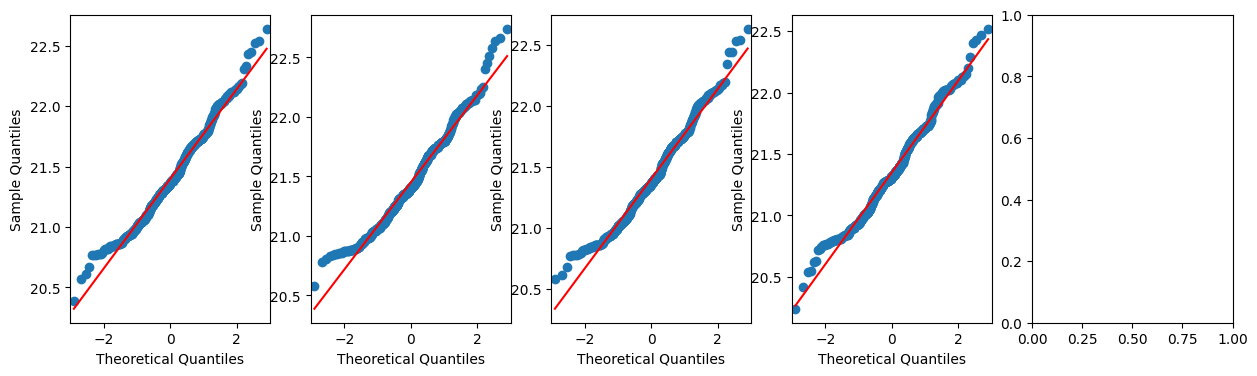

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))

qqplot(SOFI_data['Open'], line='s', ax=axs[0])
qqplot(SOFI_data['High'], line='s', ax=axs[1])
qqplot(SOFI_data['Close'], line='s', ax=axs[2])
qqplot(SOFI_data['Low'], line='s', ax=axs[3])

plt.show()

In [ ]:
Open = SOFI_data["Open"].reset_index(drop=True)
total_size = len(Open)

train_end = int(0.7 * total_size)
val_end = int(0.9 * total_size)

train = Open.iloc[:train_end]
valid = Open.iloc[train_end:val_end]
test = Open.iloc[val_end:]

def create_features_targets(open_series):
    df = pd.DataFrame({'Open': open_series})
    df['Shift1'] = df['Open'].shift(1)
    df['Shift2'] = df['Open'].shift(2)
    df['Shift3'] = df['Open'].shift(3)
    df['Target'] = (df['Open'].shift(-1) > df['Open']).astype(int)
    df.dropna(inplace=True)
    return df[['Shift1', 'Shift2', 'Shift3']], df['Target']

full_df = pd.DataFrame({'Open': Open})
full_df['Shift1'] = full_df['Open'].shift(1)
full_df['Shift2'] = full_df['Open'].shift(2)
full_df['Shift3'] = full_df['Open'].shift(3)
full_df['Target'] = (full_df['Open'].shift(-1) > full_df['Open']).astype(int)
full_df.dropna(inplace=True)

full_df.reset_index(drop=True, inplace=True)

total_size = len(full_df)
train_end = int(0.7 * total_size)
val_end = int(0.9 * total_size)

train_df = full_df.iloc[:train_end]
valid_df = full_df.iloc[train_end:val_end]
test_df  = full_df.iloc[val_end:]

X_train, y_train = train_df[['Shift1', 'Shift2', 'Shift3']], train_df['Target']
X_valid, y_valid = valid_df[['Shift1', 'Shift2', 'Shift3']], valid_df['Target']
X_test, y_test   = test_df[['Shift1', 'Shift2', 'Shift3']], test_df['Target']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)
X_train_2d, X_test_2d = X_train_scaled.copy(), X_test_scaled.copy()
X_train_3d = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_3d  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# SOFI Excel Sheet

In [ ]:
'''
Open.dtypes

Open['Datetime'] = Open['Datetime'].dt.tz_localize(None)
print(Open.head())
'''

"\nOpen.dtypes\n\nOpen['Datetime'] = Open['Datetime'].dt.tz_localize(None)\nprint(Open.head())\n"

In [ ]:
print(Open.head())

0    20.389999
1    20.570000
2    20.775000
3    21.084999
4    21.139999
Name: Open, dtype: float64


In [ ]:
'''
with pd.ExcelWriter('SOFI_data.xlsx') as writer:
    if isinstance(SOFI_data.index, pd.DatetimeIndex):
        SOFI_data.index = SOFI_data.index.tz_localize(None)
    Open['Datetime'] = Open['Datetime'].dt.tz_localize(None)
    train['Datetime'] = train['Datetime'].dt.tz_localize(None)
    valid['Datetime'] = valid['Datetime'].dt.tz_localize(None)
    test['Datetime'] = test['Datetime'].dt.tz_localize(None)

    SOFI_data.to_excel(writer, sheet_name='SOFI_data')
    Open.to_excel(writer, sheet_name='Open')
    train.to_excel(writer, sheet_name='train')
    valid.to_excel(writer, sheet_name='valid')
    test.to_excel(writer, sheet_name='test')

files.download('SOFI_data.xlsx')
'''

"\nwith pd.ExcelWriter('SOFI_data.xlsx') as writer:\n    if isinstance(SOFI_data.index, pd.DatetimeIndex):\n        SOFI_data.index = SOFI_data.index.tz_localize(None)\n    Open['Datetime'] = Open['Datetime'].dt.tz_localize(None)\n    train['Datetime'] = train['Datetime'].dt.tz_localize(None)\n    valid['Datetime'] = valid['Datetime'].dt.tz_localize(None)\n    test['Datetime'] = test['Datetime'].dt.tz_localize(None)\n\n    SOFI_data.to_excel(writer, sheet_name='SOFI_data')\n    Open.to_excel(writer, sheet_name='Open')\n    train.to_excel(writer, sheet_name='train')\n    valid.to_excel(writer, sheet_name='valid')\n    test.to_excel(writer, sheet_name='test')\n\nfiles.download('SOFI_data.xlsx')\n"

# SOFI GD Boost

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.15,
                                 random_state=40, max_features=2)
gbc.fit(X_train_2d, y_train)
gbc_proba = gbc.predict_proba(X_test_2d)[:, 1]
gbc_preds = gbc.predict(X_test_2d)
gbc_acc = accuracy_score(y_test, gbc_preds)
print("Gradient Boosting Accuracy:", gbc_acc)


Gradient Boosting Accuracy: 0.4716981132075472


In [ ]:
'''
warnings.filterwarnings('ignore')
def plot_roc_curve(n, X_train, y_train, classifier, X_test, y_test):
    cv = StratifiedKFold(n_splits=n)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X_train, train_y)):
        X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]
        X_test_fold, y_test_fold = X_train.iloc[test], y_train.iloc[test]

        classifier.fit(X_train_fold, y_train_fold)
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_test_fold,
            y_test_fold,
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == n-1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve based off GD Boost",
    )
    ax.legend(loc="upper left", fontsize = 7)
    plt.show()


plot_roc_curve(n=5, X_train=train_X, y_train=train_y, classifier=gbc, X_test=test_X, y_test=test_y)
'''

'\nwarnings.filterwarnings(\'ignore\')\ndef plot_roc_curve(n, X_train, y_train, classifier, X_test, y_test):\n    cv = StratifiedKFold(n_splits=n)\n    tprs = []\n    aucs = []\n    mean_fpr = np.linspace(0, 1, 100)\n\n    fig, ax = plt.subplots(figsize=(6, 6))\n    for fold, (train, test) in enumerate(cv.split(X_train, train_y)):\n        X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]\n        X_test_fold, y_test_fold = X_train.iloc[test], y_train.iloc[test]\n\n        classifier.fit(X_train_fold, y_train_fold)\n        viz = RocCurveDisplay.from_estimator(\n            classifier,\n            X_test_fold,\n            y_test_fold,\n            name=f"ROC fold {fold}",\n            alpha=0.3,\n            lw=1,\n            ax=ax,\n            plot_chance_level=(fold == n-1),\n        )\n        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)\n        interp_tpr[0] = 0.0\n        tprs.append(interp_tpr)\n        aucs.append(viz.roc_auc)\n\n    mean_tpr = np.

# SOFI Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=30)
rf.fit(X_train_2d, y_train)
rf_proba = rf.predict_proba(X_test_2d)[:, 1]
rf_preds = rf.predict(X_test_2d)
rf_acc = accuracy_score(y_test, rf_preds)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 0.5471698113207547


In [ ]:
'''
def plot_roc_curve_rf(n, X_train, y_train, classifier, X_test, y_test):
    cv = StratifiedKFold(n_splits=n)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]
        X_test_fold, y_test_fold = X_train.iloc[test], y_train.iloc[test]

        classifier.fit(X_train_fold, y_train_fold)
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_test_fold,
            y_test_fold,
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == n-1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve based off Random Forest",
    )
    ax.legend(loc="upper left", fontsize=7)
    plt.show()

rf_clf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=40)

plot_roc_curve_rf(n=5, X_train=train_X, y_train=train_y, classifier=rf_clf, X_test=test_X, y_test=test_y)
'''

'\ndef plot_roc_curve_rf(n, X_train, y_train, classifier, X_test, y_test):\n    cv = StratifiedKFold(n_splits=n)\n    tprs = []\n    aucs = []\n    mean_fpr = np.linspace(0, 1, 100)\n\n    fig, ax = plt.subplots(figsize=(6, 6))\n    for fold, (train, test) in enumerate(cv.split(X_train, y_train)):\n        X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]\n        X_test_fold, y_test_fold = X_train.iloc[test], y_train.iloc[test]\n\n        classifier.fit(X_train_fold, y_train_fold)\n        viz = RocCurveDisplay.from_estimator(\n            classifier,\n            X_test_fold,\n            y_test_fold,\n            name=f"ROC fold {fold}",\n            alpha=0.3,\n            lw=1,\n            ax=ax,\n            plot_chance_level=(fold == n-1),\n        )\n        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)\n        interp_tpr[0] = 0.0\n        tprs.append(interp_tpr)\n        aucs.append(viz.roc_auc)\n\n    mean_tpr = np.mean(tprs, axis=0)\n    mean_tpr[-

# SOFI LSTM

In [ ]:
Open_df = pd.DataFrame({'Open': Open})
Open_df['Shift1'] = Open_df['Open'].shift(1)
Open_df['Shift2'] = Open_df['Open'].shift(2)
Open_df['Shift3'] = Open_df['Open'].shift(3)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_3d, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_proba = model.predict(X_test_3d).ravel()
lstm_acc = model.evaluate(X_test_3d, y_test, verbose=0)[1]
print("LSTM Accuracy:", lstm_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
LSTM Accuracy: 0.49056604504585266


In [ ]:
'''
def plot_roc_curve_lstm_3d(n, X_train, y_train, model, X_test, y_test):
    cv = StratifiedKFold(n_splits=n)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X_train, y_train)):

        X_train_fold, y_train_fold = X_train[train], y_train[train]
        X_test_fold, y_test_fold = X_train[test], y_train[test]

        model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

        pred_proba = model.predict(X_test_fold)

        fpr, tpr, _ = roc_curve(y_test_fold, pred_proba)
        auc_score = auc(fpr, tpr)

        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc_score)

        ax.plot(fpr, tpr, alpha=0.3, lw=1)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve based off LSTM (3D data)",
    )
    ax.legend(loc="upper left", fontsize=7)
    plt.show()

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
model = Sequential([
    LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

plot_roc_curve_lstm_3d(n=5, X_train=train_X, y_train=train_y, model=model, X_test=test_X, y_test=test_y)
'''

'\ndef plot_roc_curve_lstm_3d(n, X_train, y_train, model, X_test, y_test):\n    cv = StratifiedKFold(n_splits=n)\n    tprs = []\n    aucs = []\n    mean_fpr = np.linspace(0, 1, 100)\n\n    fig, ax = plt.subplots(figsize=(6, 6))\n    for fold, (train, test) in enumerate(cv.split(X_train, y_train)):\n\n        X_train_fold, y_train_fold = X_train[train], y_train[train]\n        X_test_fold, y_test_fold = X_train[test], y_train[test]\n\n        model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)\n\n        pred_proba = model.predict(X_test_fold)\n\n        fpr, tpr, _ = roc_curve(y_test_fold, pred_proba)\n        auc_score = auc(fpr, tpr)\n\n        interp_tpr = np.interp(mean_fpr, fpr, tpr)\n        interp_tpr[0] = 0.0\n        tprs.append(interp_tpr)\n        aucs.append(auc_score)\n\n        ax.plot(fpr, tpr, alpha=0.3, lw=1)\n\n    mean_tpr = np.mean(tprs, axis=0)\n    mean_tpr[-1] = 1.0\n    mean_auc = auc(mean_fpr, mean_tpr)\n    std_auc = np.std(aucs)\n\n    

# Screenshot of RSI and MACD for SOFI

In [ ]:
'''
from google.colab import files
uploaded = files.upload()
'''

'\nfrom google.colab import files\nuploaded = files.upload()\n'

In [ ]:
'''
import cv2
SOFI1 = cv2.imread('/content/SOFI_RSI_MACD (1).png')
SOFI1 = cv2.cvtColor(SOFI1, cv2.COLOR_BGR2RGB)
plt.imshow(SOFI1)
plt.show()
'''

"\nimport cv2\nSOFI1 = cv2.imread('/content/SOFI_RSI_MACD (1).png')\nSOFI1 = cv2.cvtColor(SOFI1, cv2.COLOR_BGR2RGB)\nplt.imshow(SOFI1)\nplt.show()\n"

# ROC Curve for SOFI

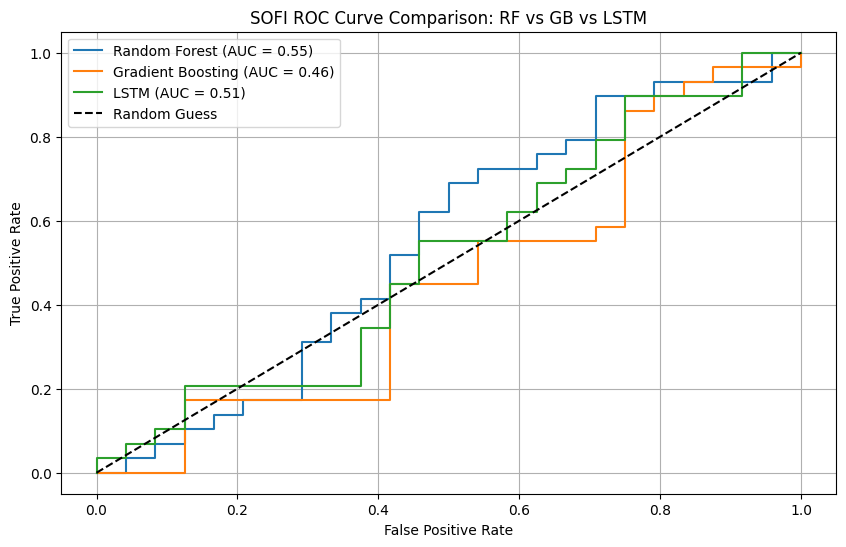

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, gbc_proba)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_proba)

auc_rf = auc(fpr_rf, tpr_rf)
auc_gbc = auc(fpr_gbc, tpr_gbc)
auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_gbc, tpr_gbc, label=f'Gradient Boosting (AUC = {auc_gbc:.2f})')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SOFI ROC Curve Comparison: RF vs GB vs LSTM')
plt.legend()
plt.grid(True)
plt.show()

# RSI for SOFI

In [ ]:
change_SOFI = SOFI_data['Open'].diff()
gain_SOFI = change_SOFI.where(change_SOFI > 0, 0)
loss_SOFI = -change_SOFI.where(change_SOFI < 0, 0)
avg_gain_SOFI  = gain_SOFI.rolling(window=14).mean()
avg_loss_SOFI = loss_SOFI.rolling(window=14).mean()
rsi_SOFI = avg_gain_SOFI / avg_loss_SOFI
SOFI_data['RSI'] = 100 - (100 / (1 + rsi_SOFI))
rsi_SOFI.dropna(inplace=True)
rsi_SOFI.head()

X_train_2d = pd.DataFrame(X_train_2d)
X_test_2d = pd.DataFrame(X_test_2d)
X_train_2d.columns = X_train_2d.columns.astype(str)
X_test_2d.columns = X_test_2d.columns.astype(str)
X_train_2d['RSI'] = rsi_SOFI.iloc[:len(X_train_2d)].values
X_test_2d['RSI'] = rsi_SOFI.iloc[len(X_train_2d):len(X_train_2d)+len(X_test_2d)].values
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.07, random_state=40, max_features=2)
gbc.fit(X_train_scaled, y_train)

SOFI_gbc_proba_rsi = gbc.predict_proba(X_test_scaled)[:, 1]
SOFI_gbc_preds_rsi = gbc.predict(X_test_scaled)
SOFI_gbc_acc_rsi = accuracy_score(y_test, SOFI_gbc_preds_rsi)

print("SOFI Gradient Boosting Accuracy with RSI:", SOFI_gbc_acc_rsi)
print("SOFI Gradient Boosting Accuracy without RSI", gbc_acc)


SOFI Gradient Boosting Accuracy with RSI: 0.41509433962264153
SOFI Gradient Boosting Accuracy without RSI 0.4716981132075472


In [ ]:
X_train_2d = pd.DataFrame(X_train_2d)
X_test_2d = pd.DataFrame(X_test_2d)
X_train_2d.columns = X_train_2d.columns.astype(str)
X_test_2d.columns = X_test_2d.columns.astype(str)
X_train_2d['RSI'] = rsi_SOFI.iloc[:len(X_train_2d)].values
X_test_2d['RSI'] = rsi_SOFI.iloc[len(X_train_2d):len(X_train_2d)+len(X_test_2d)].values

rf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=30)
rf.fit(X_train_2d, y_train)
rf_proba = rf.predict_proba(X_test_2d)[:, 1]
rf_preds = rf.predict(X_test_2d)
rf_acc = accuracy_score(y_test, rf_preds)

print("Random Forest Accuracy with RSI:", rf_acc)


Random Forest Accuracy with RSI: 0.37735849056603776


In [ ]:
'''
aligned_data = SOFI_data.loc[rsi_SOFI.index]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
ax1.plot(aligned_data.index, aligned_data['Open'], label='SOFI Open Price', color='blue')
ax1.set_title('SOFI Open Price')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

ax2.plot(rsi_SOFI.index, rsi_SOFI, label='RSI (14)', color='purple')
ax2.axhline(70, color='red', linestyle='--', linewidth=1)
ax2.axhline(30, color='green', linestyle='--', linewidth=1)
ax2.set_title('Relative Strength Index (RSI)')
ax2.set_ylabel('RSI Value')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
'''

"\naligned_data = SOFI_data.loc[rsi_SOFI.index]\nfig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)\nax1.plot(aligned_data.index, aligned_data['Open'], label='SOFI Open Price', color='blue')\nax1.set_title('SOFI Open Price')\nax1.set_ylabel('Price')\nax1.legend()\nax1.grid(True)\n\nax2.plot(rsi_SOFI.index, rsi_SOFI, label='RSI (14)', color='purple')\nax2.axhline(70, color='red', linestyle='--', linewidth=1)\nax2.axhline(30, color='green', linestyle='--', linewidth=1)\nax2.set_title('Relative Strength Index (RSI)')\nax2.set_ylabel('RSI Value')\nax2.set_xlabel('Date')\nax2.legend()\nax2.grid(True)\n\nplt.tight_layout()\nplt.show()\n"

#Paper Trade for SOFI

In [ ]:
SOFI_Money = Money('1000000.00', 'USD')
Initial_Investment = SOFI_Money.amount
Shares = 0
Portfolio_value = Initial_Investment
buy_threshold = 30
sell_threshold = 70
Trade_log = []

SOFI_data['Buy_Signal'] = (SOFI_data['RSI'] < buy_threshold)
SOFI_data['Sell_Signal'] = (SOFI_data['RSI'] > sell_threshold)

SOFI_data['Signal'] = 'Hold'
SOFI_data.loc[SOFI_data['Buy_Signal'], 'Signal'] = 'Buy'
SOFI_data.loc[SOFI_data['Sell_Signal'], 'Signal'] = 'Sell'

for i in range(1, len(SOFI_data)):
    current_date = SOFI_data.index[i]
    current_rsi = SOFI_data['RSI'].iloc[i]
    current_open = SOFI_data['Open'].iloc[i]
    current_open_decimal = Decimal(str(current_open))

    if current_rsi < buy_threshold and SOFI_Money.amount >= current_open_decimal:
        num_shares_to_buy = int(SOFI_Money.amount // current_open_decimal)
        if num_shares_to_buy > 0:
            new_amount = SOFI_Money.amount - (num_shares_to_buy * current_open_decimal)
            SOFI_Money = Money(str(new_amount), 'USD')
            Shares += num_shares_to_buy
            Trade_log.append(f"{current_date}: Bought {num_shares_to_buy} shares at {current_open_decimal:.2f} USD")

    elif current_rsi > sell_threshold and Shares > 0:
        new_amount = SOFI_Money.amount + (Shares * current_open_decimal)
        SOFI_Money = Money(str(new_amount), 'USD')
        Trade_log.append(f"{current_date}: Sold {Shares} shares at {current_open_decimal:.2f} USD")
        Shares = 0

    Portfolio_value = SOFI_Money.amount + (Shares * current_open_decimal)



final_value = Portfolio_value
total_return = final_value - Initial_Investment
total_percentage_return = (total_return / Initial_Investment) * 100

print(f"Final Portfolio Value: {final_value:,.2f} USD")
print(f"Total Return: {total_return:,.2f} USD")
print(f"Total Percentage Return: {total_percentage_return:.2f}%")

for trade in Trade_log:
    print(trade)


Final Portfolio Value: 1,022,910.00 USD
Total Return: 22,910.00 USD
Total Percentage Return: 2.29%
28: Bought 47996 shares at 20.83 USD
73: Sold 47996 shares at 21.04 USD
136: Bought 47112 shares at 21.43 USD
185: Sold 47112 shares at 21.29 USD
230: Bought 47592 shares at 21.08 USD
244: Sold 47592 shares at 21.44 USD
269: Bought 48245 shares at 21.16 USD
345: Sold 48245 shares at 21.17 USD
403: Bought 47021 shares at 21.72 USD
413: Sold 47021 shares at 21.92 USD
469: Bought 47236 shares at 21.82 USD
509: Sold 47236 shares at 21.66 USD


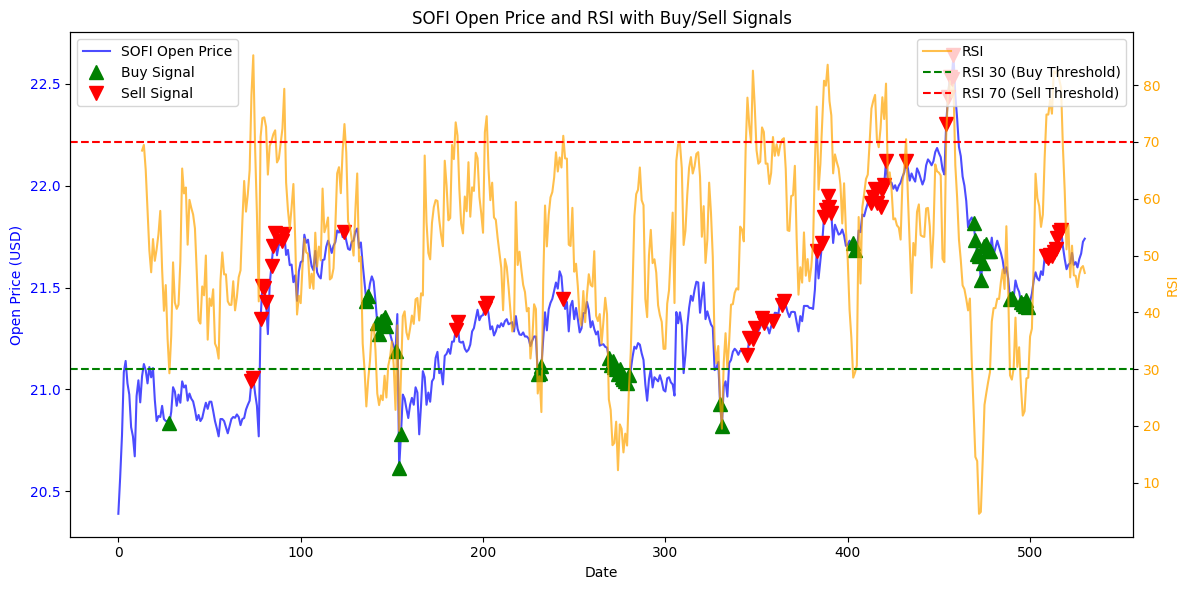

          Open        RSI Signal
526  21.599001  44.435642   Hold
527  21.639999  46.661597   Hold
528  21.666500  47.796901   Hold
529  21.725000  48.145358   Hold
530  21.740000  46.924818   Hold


In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(SOFI_data.index, SOFI_data['Open'], label="SOFI Open Price", color='blue', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Open Price (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1.plot(SOFI_data.index[SOFI_data['Buy_Signal']], SOFI_data['Open'][SOFI_data['Buy_Signal']], '^', markersize=10, color='green', label='Buy Signal')
ax1.plot(SOFI_data.index[SOFI_data['Sell_Signal']], SOFI_data['Open'][SOFI_data['Sell_Signal']], 'v', markersize=10, color='red', label='Sell Signal')

ax2 = ax1.twinx()
ax2.plot(SOFI_data.index, SOFI_data['RSI'], label="RSI", color='orange', alpha=0.7)
ax2.axhline(y=30, color='green', linestyle='--', label='RSI 30 (Buy Threshold)')
ax2.axhline(y=70, color='red', linestyle='--', label='RSI 70 (Sell Threshold)')
ax2.set_ylabel('RSI', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("SOFI Open Price and RSI with Buy/Sell Signals")
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

print(SOFI_data[['Open', 'RSI', 'Signal']].tail())


# Denoised SOFI

In [ ]:
SOFI = yf.Ticker("SOFI")
SOFI_data = SOFI.history(start="2025-07-10", end="2025-07-20", interval = '5m')
SOFI_data = SOFI_data.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
SOFI_data =  SOFI_data[SOFI_data.Open != SOFI_data.Close]
SOFI_data = SOFI_data.reset_index()


def moving_average_filter(data, window_size):
    window = np.ones(window_size) / float(window_size)
    convolved_data = np.convolve(data, window, 'same')
    print("Original data: {}".format(data[:10]))
    print("Moving average filtered data with window size {}: {}".format(window_size, convolved_data[:10]))
    return convolved_data

window_size = 4

open_prices = SOFI_data['Open'].values
denoised_open = moving_average_filter(open_prices, window_size)
SOFI_data['Denoised_Open'] = denoised_open
print(SOFI_data[['Datetime', 'Open', 'Denoised_Open']].head(10))

Original data: [20.38999939 20.56999969 20.77499962 21.08499908 21.13999939 21.0298996
 20.97500038 20.81500053 20.77000046 20.6718998 ]
Moving average filtered data with window size 4: [10.23999977 15.43374968 20.70499945 20.89249945 21.00747442 21.05747461
 20.98997498 20.89747524 20.80797529 20.80614996]
                   Datetime       Open  Denoised_Open
0 2025-07-10 09:30:00-04:00  20.389999      10.240000
1 2025-07-10 09:35:00-04:00  20.570000      15.433750
2 2025-07-10 09:40:00-04:00  20.775000      20.704999
3 2025-07-10 09:45:00-04:00  21.084999      20.892499
4 2025-07-10 09:50:00-04:00  21.139999      21.007474
5 2025-07-10 09:55:00-04:00  21.029900      21.057475
6 2025-07-10 10:00:00-04:00  20.975000      20.989975
7 2025-07-10 10:05:00-04:00  20.815001      20.897475
8 2025-07-10 10:10:00-04:00  20.770000      20.807975
9 2025-07-10 10:15:00-04:00  20.671900      20.806150


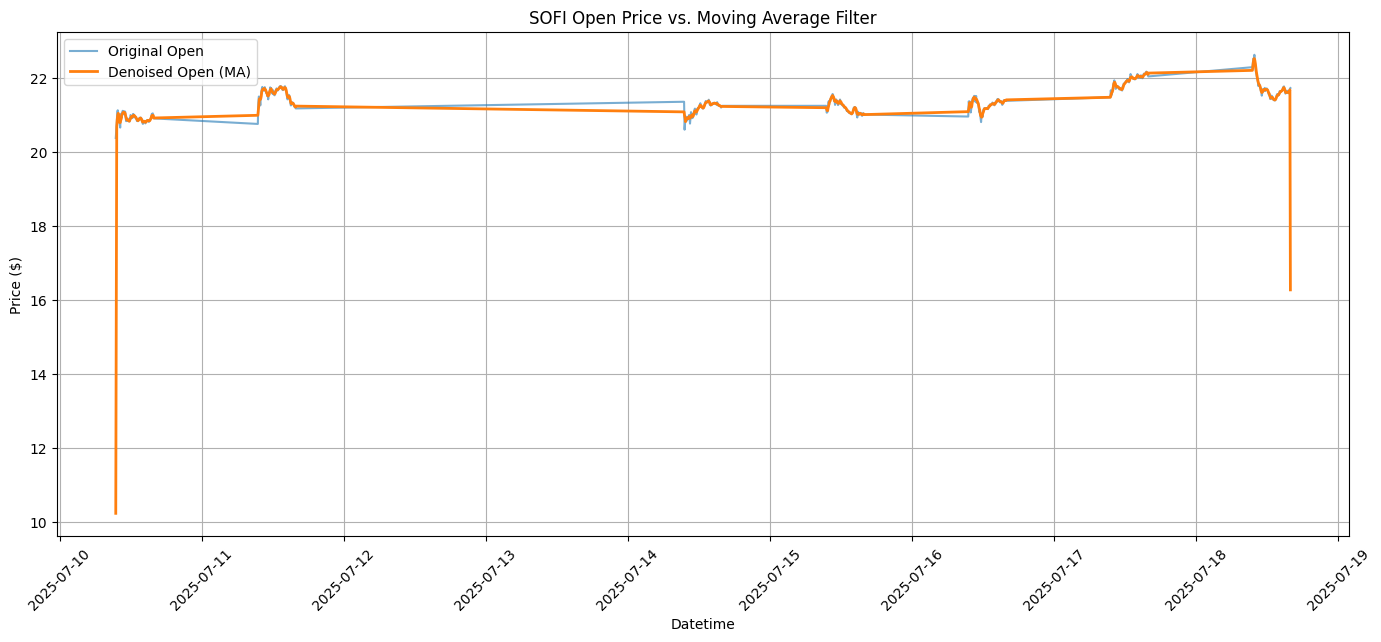

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(SOFI_data['Datetime'], SOFI_data['Open'], label='Original Open', alpha=0.6)
plt.plot(SOFI_data['Datetime'], SOFI_data['Denoised_Open'], label='Denoised Open (MA)', linewidth=2)

plt.title('SOFI Open Price vs. Moving Average Filter')
plt.xlabel('Datetime')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [ ]:
gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.15,
                                 random_state=40, max_features=2)
gbc.fit(X_train_2d, y_train)
gbc_proba = gbc.predict_proba(X_test_2d)[:, 1]
gbc_preds = gbc.predict(X_test_2d)
gbc_acc = accuracy_score(y_test, gbc_preds)
print("Gradient Boosting Accuracy:", gbc_acc)


Gradient Boosting Accuracy: 0.37735849056603776


In [ ]:
rf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=30)
rf.fit(X_train_2d, y_train)
rf_proba = rf.predict_proba(X_test_2d)[:, 1]
rf_preds = rf.predict(X_test_2d)
rf_acc = accuracy_score(y_test, rf_preds)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 0.37735849056603776


In [ ]:
Open_df = pd.DataFrame({'Open': Open})
Open_df['Shift1'] = Open_df['Open'].shift(1)
Open_df['Shift2'] = Open_df['Open'].shift(2)
Open_df['Shift3'] = Open_df['Open'].shift(3)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_3d, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_proba = model.predict(X_test_3d).ravel()
lstm_acc = model.evaluate(X_test_3d, y_test, verbose=0)[1]
print("LSTM Accuracy:", lstm_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
LSTM Accuracy: 0.5660377144813538


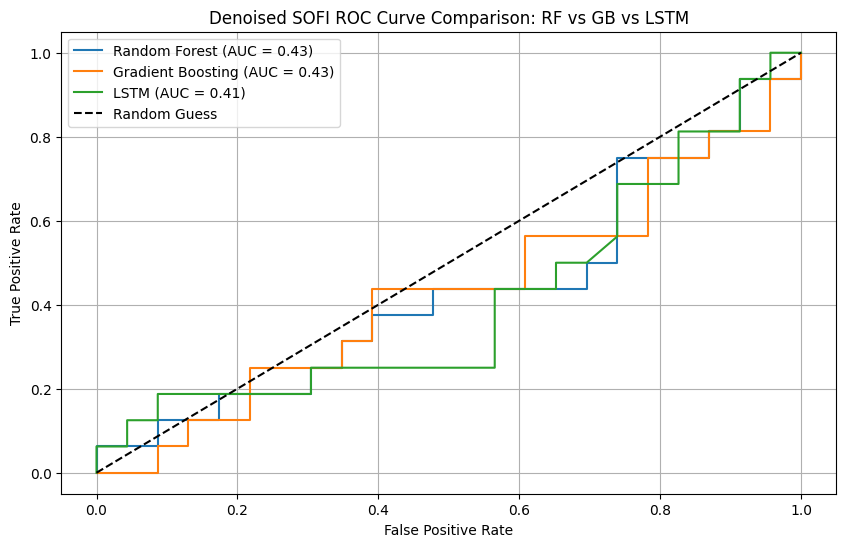

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, gbc_proba)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_proba)

auc_rf = auc(fpr_rf, tpr_rf)
auc_gbc = auc(fpr_gbc, tpr_gbc)
auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_gbc, tpr_gbc, label=f'Gradient Boosting (AUC = {auc_gbc:.2f})')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Denoised SOFI ROC Curve Comparison: RF vs GB vs LSTM')
plt.legend()
plt.grid(True)
plt.show()

# NOA Data for Project

In [ ]:
NOA = yf.Ticker("NOA")
NOA_data = NOA.history(start="2025-07-10", end="2025-07-20", interval = '5m')
NOA_data = NOA_data.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
print(NOA_data)

                                Open       High        Low      Close  Volume  \
Datetime                                                                        
2025-07-10 09:30:00-04:00  16.559999  16.559999  16.559999  16.559999     664   
2025-07-10 09:35:00-04:00  16.639999  16.639999  16.639999  16.639999     348   
2025-07-10 09:40:00-04:00  16.635000  16.639999  16.635000  16.635000     500   
2025-07-10 09:45:00-04:00  16.635000  16.670000  16.600000  16.670000     632   
2025-07-10 09:55:00-04:00  16.690001  16.690001  16.690001  16.690001     192   
...                              ...        ...        ...        ...     ...   
2025-07-18 15:35:00-04:00  15.300000  15.300000  15.300000  15.300000     398   
2025-07-18 15:40:00-04:00  15.300000  15.310000  15.300000  15.305000    1007   
2025-07-18 15:45:00-04:00  15.305000  15.320000  15.300000  15.320000    1510   
2025-07-18 15:50:00-04:00  15.300000  15.319900  15.290000  15.295000    2670   
2025-07-18 15:55:00-04:00  1

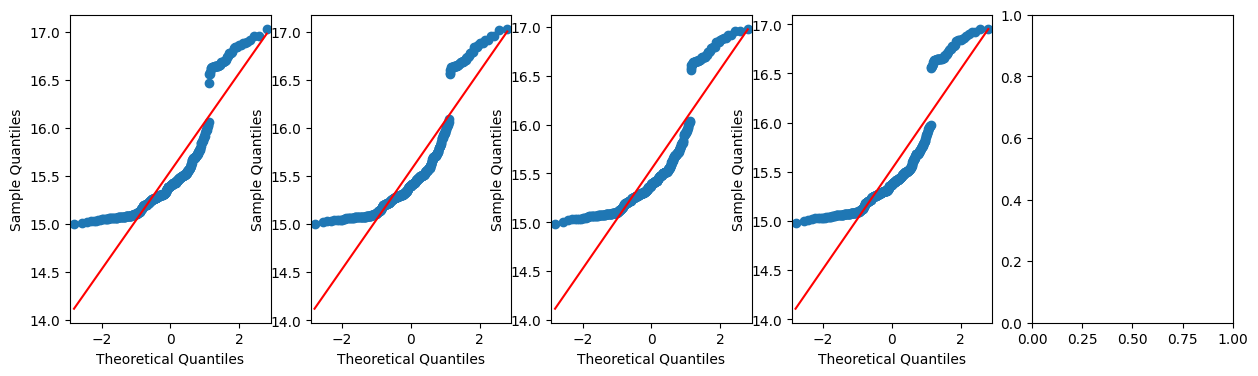

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))

qqplot(NOA_data['Open'], line='s', ax=axs[0])
qqplot(NOA_data['High'], line='s', ax=axs[1])
qqplot(NOA_data['Close'], line='s', ax=axs[2])
qqplot(NOA_data['Low'], line='s', ax=axs[3])

plt.show()

In [ ]:
Open = NOA_data["Open"].reset_index(drop=True)
total_size = len(Open)

train_end = int(0.7 * total_size)
val_end = int(0.9 * total_size)

train = Open.iloc[:train_end]
valid = Open.iloc[train_end:val_end]
test = Open.iloc[val_end:]

def create_features_targets(open_series):
    df = pd.DataFrame({'Open': open_series})
    df['Shift1'] = df['Open'].shift(1)
    df['Shift2'] = df['Open'].shift(2)
    df['Shift3'] = df['Open'].shift(3)
    df['Target'] = (df['Open'].shift(-1) > df['Open']).astype(int)
    df.dropna(inplace=True)
    return df[['Shift1', 'Shift2', 'Shift3']], df['Target']

full_df = pd.DataFrame({'Open': Open})
full_df['Shift1'] = full_df['Open'].shift(1)
full_df['Shift2'] = full_df['Open'].shift(2)
full_df['Shift3'] = full_df['Open'].shift(3)
full_df['Target'] = (full_df['Open'].shift(-1) > full_df['Open']).astype(int)
full_df.dropna(inplace=True)

full_df.reset_index(drop=True, inplace=True)

total_size = len(full_df)
train_end = int(0.7 * total_size)
val_end = int(0.9 * total_size)

train_df = full_df.iloc[:train_end]
valid_df = full_df.iloc[train_end:val_end]
test_df  = full_df.iloc[val_end:]

X_train, y_train = train_df[['Shift1', 'Shift2', 'Shift3']], train_df['Target']
X_valid, y_valid = valid_df[['Shift1', 'Shift2', 'Shift3']], valid_df['Target']
X_test, y_test   = test_df[['Shift1', 'Shift2', 'Shift3']], test_df['Target']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)
X_train_2d, X_test_2d = X_train_scaled.copy(), X_test_scaled.copy()
X_train_3d = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_3d  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# NOA Excel Sheet

In [ ]:
'''
Open.dtypes

Open['Datetime'] = Open['Datetime'].dt.tz_localize(None)
print(Open.head())
'''

"\nOpen.dtypes\n\nOpen['Datetime'] = Open['Datetime'].dt.tz_localize(None)\nprint(Open.head())\n"

In [ ]:
'''
with pd.ExcelWriter('NOA_data.xlsx') as writer:
    if isinstance(NOA_data.index, pd.DatetimeIndex):
        NOA_data.index = NOA_data.index.tz_localize(None)
    Open['Datetime'] = Open['Datetime'].dt.tz_localize(None)
    train['Datetime'] = train['Datetime'].dt.tz_localize(None)
    valid['Datetime'] = valid['Datetime'].dt.tz_localize(None)
    test['Datetime'] = test['Datetime'].dt.tz_localize(None)

    NOA_data.to_excel(writer, sheet_name='NOA_data')
    Open.to_excel(writer, sheet_name='Open')
    train.to_excel(writer, sheet_name='train')
    valid.to_excel(writer, sheet_name='valid')
    test.to_excel(writer, sheet_name='test')

files.download('NOA_data.xlsx')
'''

"\nwith pd.ExcelWriter('NOA_data.xlsx') as writer:\n    if isinstance(NOA_data.index, pd.DatetimeIndex):\n        NOA_data.index = NOA_data.index.tz_localize(None)\n    Open['Datetime'] = Open['Datetime'].dt.tz_localize(None)\n    train['Datetime'] = train['Datetime'].dt.tz_localize(None)\n    valid['Datetime'] = valid['Datetime'].dt.tz_localize(None)\n    test['Datetime'] = test['Datetime'].dt.tz_localize(None)\n\n    NOA_data.to_excel(writer, sheet_name='NOA_data')\n    Open.to_excel(writer, sheet_name='Open')\n    train.to_excel(writer, sheet_name='train')\n    valid.to_excel(writer, sheet_name='valid')\n    test.to_excel(writer, sheet_name='test')\n\nfiles.download('NOA_data.xlsx')\n"

# NOA GD Boost

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.15,
                                 random_state=42, max_features=2)
gbc.fit(X_train_2d, y_train)
gbc_proba = gbc.predict_proba(X_test_2d)[:, 1]
gbc_preds = gbc.predict(X_test_2d)
gbc_acc = accuracy_score(y_test, gbc_preds)
print("Gradient Boosting Accuracy:", gbc_acc)


Gradient Boosting Accuracy: 0.5641025641025641


# NOA Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=42)
rf.fit(X_train_2d, y_train)
rf_proba = rf.predict_proba(X_test_2d)[:, 1]
rf_preds = rf.predict(X_test_2d)
rf_acc = accuracy_score(y_test, rf_preds)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 0.5897435897435898


# NOA LSTM

In [ ]:
Open_df = pd.DataFrame({'Open': Open})
Open_df['Shift1'] = Open_df['Open'].shift(1)
Open_df['Shift2'] = Open_df['Open'].shift(2)
Open_df['Shift3'] = Open_df['Open'].shift(3)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_3d, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_proba = model.predict(X_test_3d).ravel()
lstm_acc = model.evaluate(X_test_3d, y_test, verbose=0)[1]
print("LSTM Accuracy:", lstm_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
LSTM Accuracy: 0.5897436141967773


# ROC Curve for NOA

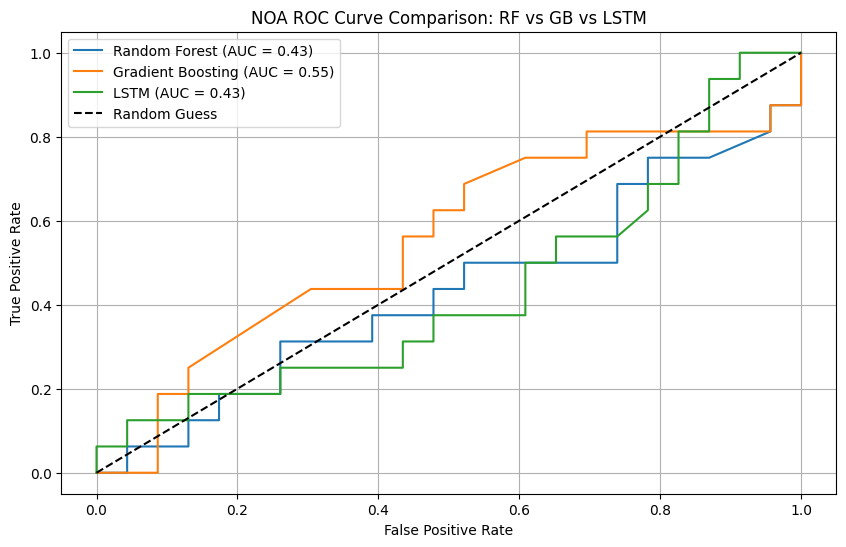

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, gbc_proba)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_proba)

auc_rf = auc(fpr_rf, tpr_rf)
auc_gbc = auc(fpr_gbc, tpr_gbc)
auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_gbc, tpr_gbc, label=f'Gradient Boosting (AUC = {auc_gbc:.2f})')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NOA ROC Curve Comparison: RF vs GB vs LSTM')
plt.legend()
plt.grid(True)
plt.show()

# RSI for NOA

In [ ]:
change_NOA = NOA_data['Open'].diff()
gain_NOA = change_NOA.where(change_NOA > 0, 0)
loss_NOA = -change_NOA.where(change_NOA < 0, 0)
avg_gain_NOA  = gain_NOA.rolling(window=14).mean()
avg_loss_NOA = loss_NOA.rolling(window=14).mean()
rsi_NOA = avg_gain_NOA / avg_loss_NOA
NOA_data['RSI'] = 100 - (100 / (1 + rsi_NOA))
rsi_NOA.dropna(inplace=True)
rsi_NOA.head()

X_train_2d = pd.DataFrame(X_train_2d)
X_test_2d = pd.DataFrame(X_test_2d)
X_train_2d.columns = X_train_2d.columns.astype(str)
X_test_2d.columns = X_test_2d.columns.astype(str)
X_train_2d['RSI'] = rsi_NOA.iloc[:len(X_train_2d)].values
X_test_2d['RSI'] = rsi_NOA.iloc[len(X_train_2d):len(X_train_2d)+len(X_test_2d)].values
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.07, random_state=40, max_features=2)
gbc.fit(X_train_scaled, y_train)

NOA_gbc_proba_rsi = gbc.predict_proba(X_test_scaled)[:, 1]
NOA_gbc_preds_rsi = gbc.predict(X_test_scaled)
NOA_gbc_acc_rsi = accuracy_score(y_test, NOA_gbc_preds_rsi)

print("NOA Gradient Boosting Accuracy with RSI:", NOA_gbc_acc_rsi)
print("NOA Gradient Boosting Accuracy without RSI", gbc_acc)


NOA Gradient Boosting Accuracy with RSI: 0.48717948717948717
NOA Gradient Boosting Accuracy without RSI 0.5641025641025641


In [ ]:
X_train_2d = pd.DataFrame(X_train_2d)
X_test_2d = pd.DataFrame(X_test_2d)
X_train_2d.columns = X_train_2d.columns.astype(str)
X_test_2d.columns = X_test_2d.columns.astype(str)
X_train_2d['RSI'] = rsi_NOA.iloc[:len(X_train_2d)].values
X_test_2d['RSI'] = rsi_NOA.iloc[len(X_train_2d):len(X_train_2d)+len(X_test_2d)].values

rf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=30)
rf.fit(X_train_2d, y_train)
rf_proba = rf.predict_proba(X_test_2d)[:, 1]
rf_preds = rf.predict(X_test_2d)
rf_acc = accuracy_score(y_test, rf_preds)

print("Random Forest Accuracy with RSI NOA:", rf_acc)


Random Forest Accuracy with RSI NOA: 0.5384615384615384


# Paper Trades for NOA

In [ ]:
NOA_Money = Money('1000000.00', 'USD')
Initial_Investment = NOA_Money.amount
Shares = 0
Portfolio_value = Initial_Investment
buy_threshold = 30
sell_threshold = 70
Trade_log = []

NOA_data['Buy_Signal'] = (NOA_data['RSI'] < buy_threshold)
NOA_data['Sell_Signal'] = (NOA_data['RSI'] > sell_threshold)

NOA_data['Signal'] = 'Hold'
NOA_data.loc[NOA_data['Buy_Signal'], 'Signal'] = 'Buy'
NOA_data.loc[NOA_data['Sell_Signal'], 'Signal'] = 'Sell'

for i in range(1, len(NOA_data)):
    current_date = NOA_data.index[i]
    current_rsi = NOA_data['RSI'].iloc[i]
    current_open = NOA_data['Open'].iloc[i]
    current_open_decimal = Decimal(str(current_open))

    if current_rsi < buy_threshold and NOA_Money.amount >= current_open_decimal:
        num_shares_to_buy = int(NOA_Money.amount // current_open_decimal)
        if num_shares_to_buy > 0:
            new_amount = NOA_Money.amount - (num_shares_to_buy * current_open_decimal)
            NOA_Money = Money(str(new_amount), 'USD')
            Shares += num_shares_to_buy
            Trade_log.append(f"{current_date}: Bought {num_shares_to_buy} shares at {current_open_decimal:.2f} USD")

    elif current_rsi > sell_threshold and Shares > 0:
        new_amount = NOA_Money.amount + (Shares * current_open_decimal)
        NOA_Money = Money(str(new_amount), 'USD')
        Trade_log.append(f"{current_date}: Sold {Shares} shares at {current_open_decimal:.2f} USD")
        Shares = 0

    Portfolio_value = NOA_Money.amount + (Shares * current_open_decimal)



final_value = Portfolio_value
total_return = final_value - Initial_Investment
total_percentage_return = (total_return / Initial_Investment) * 100

print(f"Final Portfolio Value: {final_value:,.2f} USD")
print(f"Total Return: {total_return:,.2f} USD")
print(f"Total Percentage Return: {total_percentage_return:.2f}%")

for trade in Trade_log:
    print(trade)


Final Portfolio Value: 915,152.29 USD
Total Return: -84,847.71 USD
Total Percentage Return: -8.48%
2025-07-10 12:10:00-04:00: Bought 59594 shares at 16.78 USD
2025-07-11 14:40:00-04:00: Sold 59594 shares at 15.69 USD
2025-07-14 10:30:00-04:00: Bought 59616 shares at 15.69 USD
2025-07-16 15:50:00-04:00: Sold 59616 shares at 15.14 USD
2025-07-17 15:50:00-04:00: Bought 59361 shares at 15.20 USD
2025-07-18 09:30:00-04:00: Sold 59361 shares at 15.38 USD
2025-07-18 11:20:00-04:00: Bought 59833 shares at 15.26 USD


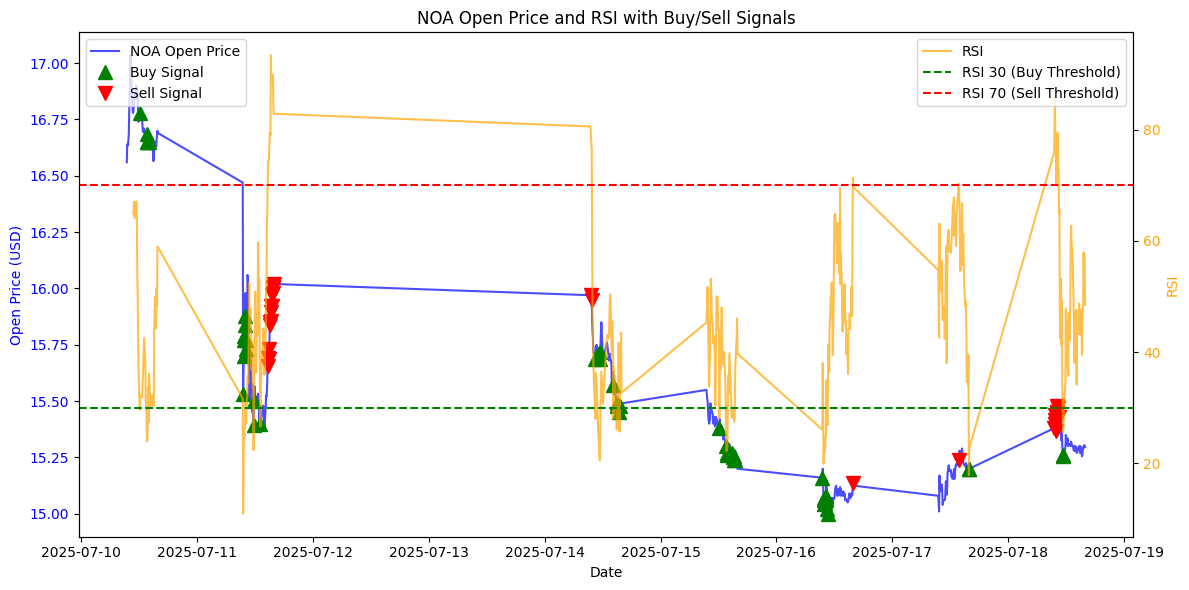

                             Open        RSI Signal
Datetime                                           
2025-07-18 15:35:00-04:00  15.300  57.936432   Hold
2025-07-18 15:40:00-04:00  15.300  54.441269   Hold
2025-07-18 15:45:00-04:00  15.305  57.143013   Hold
2025-07-18 15:50:00-04:00  15.300  52.941242   Hold
2025-07-18 15:55:00-04:00  15.295  48.484813   Hold


In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(NOA_data.index, NOA_data['Open'], label="NOA Open Price", color='blue', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Open Price (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1.plot(NOA_data.index[NOA_data['Buy_Signal']], NOA_data['Open'][NOA_data['Buy_Signal']], '^', markersize=10, color='green', label='Buy Signal')
ax1.plot(NOA_data.index[NOA_data['Sell_Signal']], NOA_data['Open'][NOA_data['Sell_Signal']], 'v', markersize=10, color='red', label='Sell Signal')

ax2 = ax1.twinx()
ax2.plot(NOA_data.index, NOA_data['RSI'], label="RSI", color='orange', alpha=0.7)
ax2.axhline(y=30, color='green', linestyle='--', label='RSI 30 (Buy Threshold)')
ax2.axhline(y=70, color='red', linestyle='--', label='RSI 70 (Sell Threshold)')
ax2.set_ylabel('RSI', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("NOA Open Price and RSI with Buy/Sell Signals")
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

print(NOA_data[['Open', 'RSI', 'Signal']].tail())

# Denoised NOA

In [ ]:
NOA = yf.Ticker("NOA")
NOA_data = NOA.history(start="2025-07-10", end="2025-07-20", interval = '5m')
NOA_data = NOA_data.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
NOA_data =  NOA_data[NOA_data.Open != NOA_data.Close]
NOA_data = NOA_data.reset_index()


def moving_average_filter(data, window_size):
    window = np.ones(window_size) / float(window_size)
    convolved_data = np.convolve(data, window, 'same')
    print("Original data: {}".format(data[:10]))
    print("Moving average filtered data with window size {}: {}".format(window_size, convolved_data[:10]))
    return convolved_data

window_size = 4

open_prices = NOA_data['Open'].values
denoised_open = moving_average_filter(open_prices, window_size)
NOA_data['Denoised_Open'] = denoised_open
print(NOA_data[['Datetime', 'Open', 'Denoised_Open']].head(10))

Original data: [16.63500023 16.86000061 16.92000008 17.03499985 16.78000069 16.82999992
 16.89999962 16.88999939 16.86499977 16.74500084]
Moving average filtered data with window size 4: [ 8.37375021 12.60375023 16.86250019 16.89875031 16.89125013 16.88625002
 16.8499999  16.87124968 16.8499999  16.78999996]
                   Datetime       Open  Denoised_Open
0 2025-07-10 09:45:00-04:00  16.635000        8.37375
1 2025-07-10 10:05:00-04:00  16.860001       12.60375
2 2025-07-10 10:10:00-04:00  16.920000       16.86250
3 2025-07-10 10:15:00-04:00  17.035000       16.89875
4 2025-07-10 10:45:00-04:00  16.780001       16.89125
5 2025-07-10 11:00:00-04:00  16.830000       16.88625
6 2025-07-10 11:30:00-04:00  16.900000       16.85000
7 2025-07-10 11:35:00-04:00  16.889999       16.87125
8 2025-07-10 11:45:00-04:00  16.865000       16.85000
9 2025-07-10 12:40:00-04:00  16.745001       16.79000


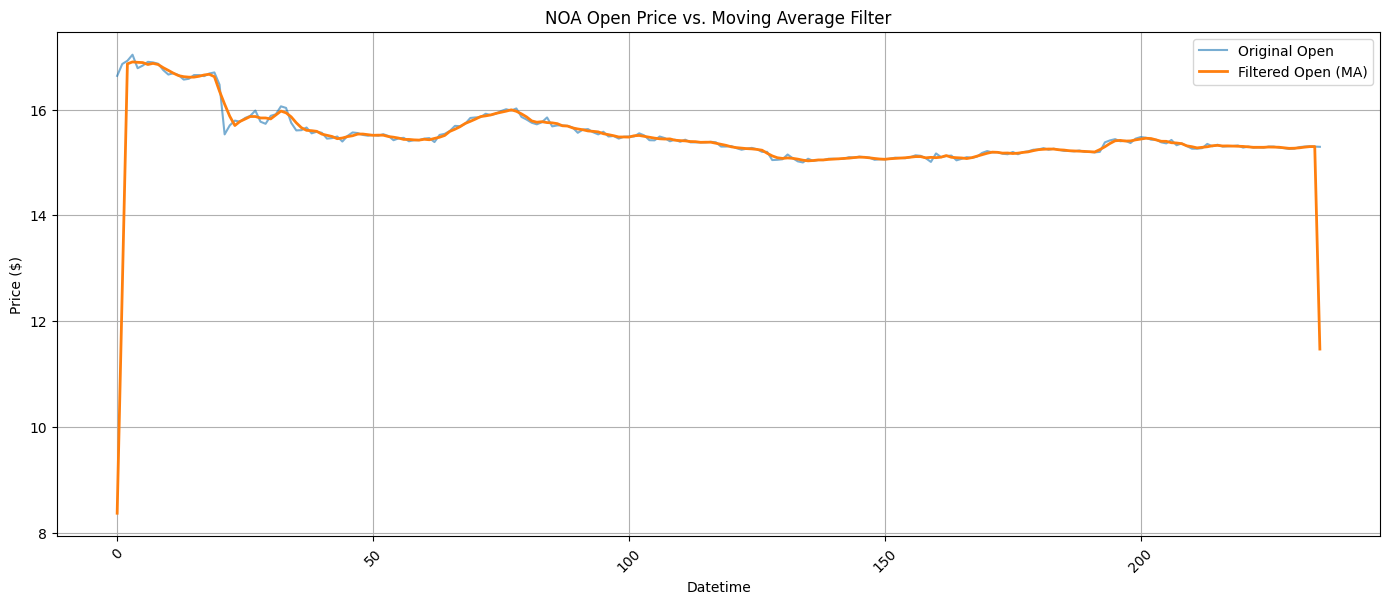

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(NOA_data.index, NOA_data['Open'], label='Original Open', alpha=0.6)
plt.plot(NOA_data.index, NOA_data['Denoised_Open'], label='Filtered Open (MA)', linewidth=2)

plt.title('NOA Open Price vs. Moving Average Filter')
plt.xlabel('Datetime')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [ ]:
gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.15,
                                 random_state=42, max_features=2)
gbc.fit(X_train_2d, y_train)
gbc_proba = gbc.predict_proba(X_test_2d)[:, 1]
gbc_preds = gbc.predict(X_test_2d)
gbc_acc = accuracy_score(y_test, gbc_preds)
print("Gradient Boosting Accuracy:", gbc_acc)


Gradient Boosting Accuracy: 0.48717948717948717


In [ ]:
rf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=42)
rf.fit(X_train_2d, y_train)
rf_proba = rf.predict_proba(X_test_2d)[:, 1]
rf_preds = rf.predict(X_test_2d)
rf_acc = accuracy_score(y_test, rf_preds)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 0.5384615384615384


In [ ]:
Open_df = pd.DataFrame({'Open': Open})
Open_df['Shift1'] = Open_df['Open'].shift(1)
Open_df['Shift2'] = Open_df['Open'].shift(2)
Open_df['Shift3'] = Open_df['Open'].shift(3)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_3d, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_proba = model.predict(X_test_3d).ravel()
lstm_acc = model.evaluate(X_test_3d, y_test, verbose=0)[1]
print("LSTM Accuracy:", lstm_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
LSTM Accuracy: 0.5897436141967773


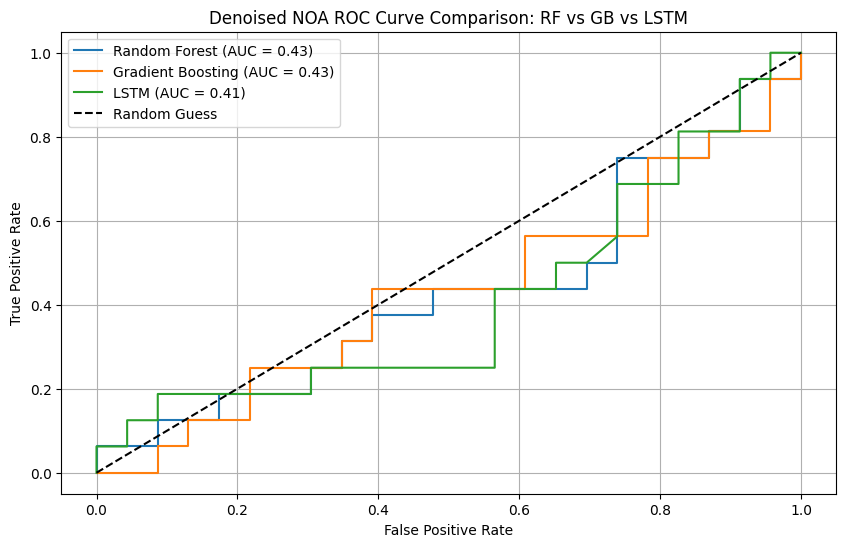

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, gbc_proba)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_proba)

auc_rf = auc(fpr_rf, tpr_rf)
auc_gbc = auc(fpr_gbc, tpr_gbc)
auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_gbc, tpr_gbc, label=f'Gradient Boosting (AUC = {auc_gbc:.2f})')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Denoised NOA ROC Curve Comparison: RF vs GB vs LSTM')
plt.legend()
plt.grid(True)
plt.show()

# BRTX Data for Project

In [ ]:
BRTX = yf.Ticker("BRTX")
BRTX_data = BRTX.history(start="2025-07-10", end="2025-07-20", interval = '5m')
BRTX_data = BRTX_data.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
print(BRTX_data)

                             Open    High     Low   Close  Volume  Dividends  \
Datetime                                                                       
2025-07-10 09:30:00-04:00  1.5700  1.5700  1.5700  1.5700    3128        0.0   
2025-07-10 09:40:00-04:00  1.5991  1.5991  1.5960  1.5960    6254        0.0   
2025-07-10 09:50:00-04:00  1.5816  1.5816  1.5816  1.5816    1793        0.0   
2025-07-10 10:50:00-04:00  1.5978  1.5978  1.5900  1.5900    1000        0.0   
2025-07-10 10:55:00-04:00  1.5850  1.5850  1.5850  1.5850     226        0.0   
...                           ...     ...     ...     ...     ...        ...   
2025-07-18 13:30:00-04:00  1.6200  1.6200  1.6200  1.6200    4426        0.0   
2025-07-18 13:40:00-04:00  1.6428  1.6428  1.6428  1.6428       0        0.0   
2025-07-18 13:50:00-04:00  1.6144  1.6144  1.6144  1.6144     400        0.0   
2025-07-18 13:55:00-04:00  1.6300  1.6300  1.6300  1.6300     104        0.0   
2025-07-18 14:20:00-04:00  1.6100  1.610

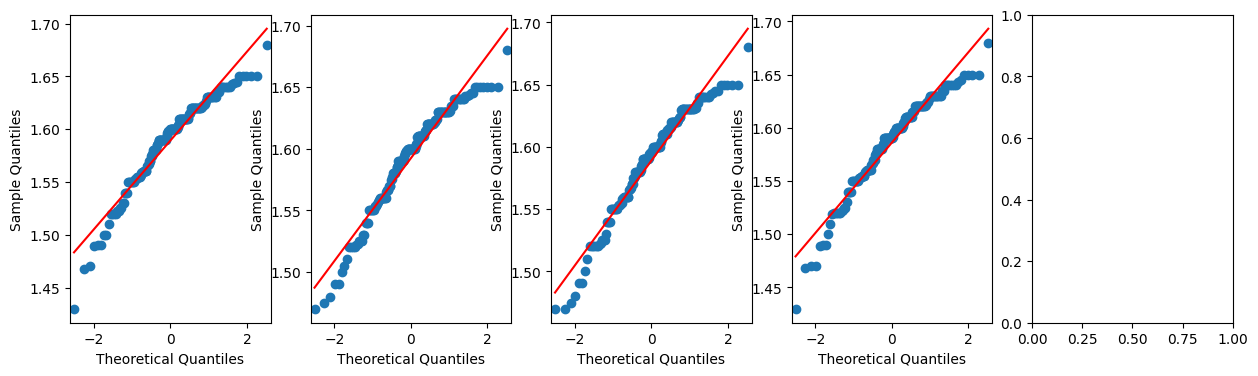

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))

qqplot(BRTX_data['Open'], line='s', ax=axs[0])
qqplot(BRTX_data['High'], line='s', ax=axs[1])
qqplot(BRTX_data['Close'], line='s', ax=axs[2])
qqplot(BRTX_data['Low'], line='s', ax=axs[3])

plt.show()

In [ ]:
Open = BRTX_data["Open"].reset_index(drop=True)
total_size = len(Open)

train_end = int(0.7 * total_size)
val_end = int(0.9 * total_size)

train = Open.iloc[:train_end]
valid = Open.iloc[train_end:val_end]
test = Open.iloc[val_end:]

def create_features_targets(open_series):
    df = pd.DataFrame({'Open': open_series})
    df['Shift1'] = df['Open'].shift(1)
    df['Shift2'] = df['Open'].shift(2)
    df['Shift3'] = df['Open'].shift(3)
    df['Target'] = (df['Open'].shift(-1) > df['Open']).astype(int)
    df.dropna(inplace=True)
    return df[['Shift1', 'Shift2', 'Shift3']], df['Target']

full_df = pd.DataFrame({'Open': Open})
full_df['Shift1'] = full_df['Open'].shift(1)
full_df['Shift2'] = full_df['Open'].shift(2)
full_df['Shift3'] = full_df['Open'].shift(3)
full_df['Target'] = (full_df['Open'].shift(-1) > full_df['Open']).astype(int)
full_df.dropna(inplace=True)

full_df.reset_index(drop=True, inplace=True)

total_size = len(full_df)
train_end = int(0.7 * total_size)
val_end = int(0.9 * total_size)

train_df = full_df.iloc[:train_end]
valid_df = full_df.iloc[train_end:val_end]
test_df  = full_df.iloc[val_end:]

X_train, y_train = train_df[['Shift1', 'Shift2', 'Shift3']], train_df['Target']
X_valid, y_valid = valid_df[['Shift1', 'Shift2', 'Shift3']], valid_df['Target']
X_test, y_test   = test_df[['Shift1', 'Shift2', 'Shift3']], test_df['Target']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)
X_train_2d, X_test_2d = X_train_scaled.copy(), X_test_scaled.copy()
X_train_3d = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_3d  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# BRTX Excel Sheet

In [ ]:
'''
Open.dtypes

Open['Datetime'] = Open['Datetime'].dt.tz_localize(None)
print(Open.head())
'''

"\nOpen.dtypes\n\nOpen['Datetime'] = Open['Datetime'].dt.tz_localize(None)\nprint(Open.head())\n"

In [ ]:
'''
with pd.ExcelWriter('BRTX_data.xlsx') as writer:
    if isinstance(BRTX_data.index, pd.DatetimeIndex):
        BRTX_data.index = BRTX_data.index.tz_localize(None)
    Open['Datetime'] = Open['Datetime'].dt.tz_localize(None)
    train['Datetime'] = train['Datetime'].dt.tz_localize(None)
    valid['Datetime'] = valid['Datetime'].dt.tz_localize(None)
    test['Datetime'] = test['Datetime'].dt.tz_localize(None)

    BRTX_data.to_excel(writer, sheet_name='BRTX_data')
    Open.to_excel(writer, sheet_name='Open')
    train.to_excel(writer, sheet_name='train')
    valid.to_excel(writer, sheet_name='valid')
    test.to_excel(writer, sheet_name='test')

files.download('BRTX_data.xlsx')
'''

"\nwith pd.ExcelWriter('BRTX_data.xlsx') as writer:\n    if isinstance(BRTX_data.index, pd.DatetimeIndex):\n        BRTX_data.index = BRTX_data.index.tz_localize(None)\n    Open['Datetime'] = Open['Datetime'].dt.tz_localize(None)\n    train['Datetime'] = train['Datetime'].dt.tz_localize(None)\n    valid['Datetime'] = valid['Datetime'].dt.tz_localize(None)\n    test['Datetime'] = test['Datetime'].dt.tz_localize(None)\n\n    BRTX_data.to_excel(writer, sheet_name='BRTX_data')\n    Open.to_excel(writer, sheet_name='Open')\n    train.to_excel(writer, sheet_name='train')\n    valid.to_excel(writer, sheet_name='valid')\n    test.to_excel(writer, sheet_name='test')\n\nfiles.download('BRTX_data.xlsx')\n"

# BRTX GD Boost

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.15,
                                 random_state=42, max_features=2)
gbc.fit(X_train_2d, y_train)
gbc_proba = gbc.predict_proba(X_test_2d)[:, 1]
gbc_preds = gbc.predict(X_test_2d)
gbc_acc = accuracy_score(y_test, gbc_preds)
print("Gradient Boosting Accuracy:", gbc_acc)


Gradient Boosting Accuracy: 0.7058823529411765


# BRTX Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=42)
rf.fit(X_train_2d, y_train)
rf_proba = rf.predict_proba(X_test_2d)[:, 1]
rf_preds = rf.predict(X_test_2d)
rf_acc = accuracy_score(y_test, rf_preds)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 0.5882352941176471


# BRTX LSTM

In [ ]:
Open_df = pd.DataFrame({'Open': Open})
Open_df['Shift1'] = Open_df['Open'].shift(1)
Open_df['Shift2'] = Open_df['Open'].shift(2)
Open_df['Shift3'] = Open_df['Open'].shift(3)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_3d, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_proba = model.predict(X_test_3d).ravel()
lstm_acc = model.evaluate(X_test_3d, y_test, verbose=0)[1]
print("LSTM Accuracy:", lstm_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
LSTM Accuracy: 0.5882353186607361


# ROC Curve for BRTX

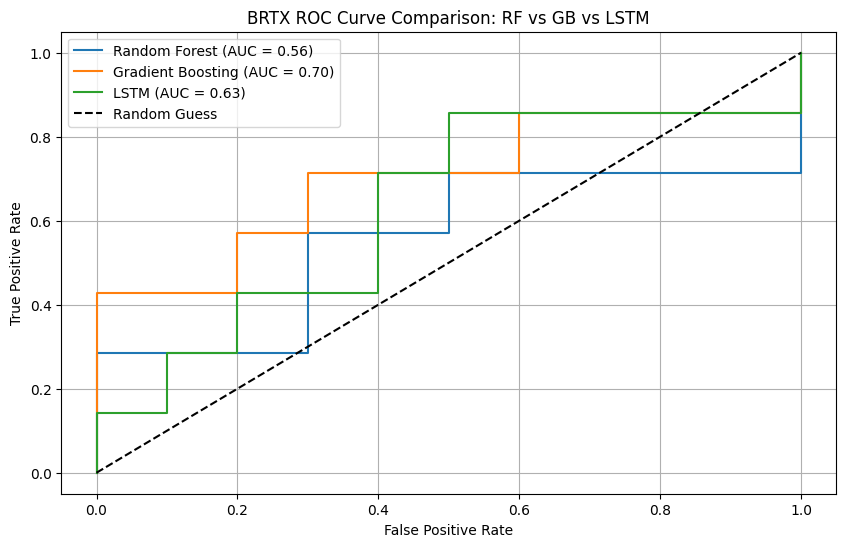

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, gbc_proba)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_proba)

auc_rf = auc(fpr_rf, tpr_rf)
auc_gbc = auc(fpr_gbc, tpr_gbc)
auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_gbc, tpr_gbc, label=f'Gradient Boosting (AUC = {auc_gbc:.2f})')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BRTX ROC Curve Comparison: RF vs GB vs LSTM')
plt.legend()
plt.grid(True)
plt.show()

# RSI for BRTX

In [ ]:
change_BRTX = BRTX_data['Open'].diff()
gain_BRTX = change_BRTX.where(change_BRTX > 0, 0)
loss_BRTX = -change_BRTX.where(change_BRTX < 0, 0)
avg_gain_BRTX  = gain_BRTX.rolling(window=14).mean()
avg_loss_BRTX = loss_BRTX.rolling(window=14).mean()
rsi_BRTX = avg_gain_BRTX / avg_loss_BRTX
BRTX_data['RSI'] = 100 - (100 / (1 + rsi_BRTX))
rsi_BRTX.dropna(inplace=True)
rsi_BRTX.head()

X_train_2d = pd.DataFrame(X_train_2d)
X_test_2d = pd.DataFrame(X_test_2d)
X_train_2d.columns = X_train_2d.columns.astype(str)
X_test_2d.columns = X_test_2d.columns.astype(str)
X_train_2d['RSI'] = rsi_BRTX.iloc[:len(X_train_2d)].values
X_test_2d['RSI'] = rsi_BRTX.iloc[len(X_train_2d):len(X_train_2d)+len(X_test_2d)].values
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.07, random_state=40, max_features=2)
gbc.fit(X_train_scaled, y_train)

BRTX_gbc_proba_rsi = gbc.predict_proba(X_test_scaled)[:, 1]
BRTX_gbc_preds_rsi = gbc.predict(X_test_scaled)
BRTX_gbc_acc_rsi = accuracy_score(y_test, BRTX_gbc_preds_rsi)

print("BRTX Gradient Boosting Accuracy with RSI:", BRTX_gbc_acc_rsi)
print("BRTX Gradient Boosting Accuracy without RSI", gbc_acc)


BRTX Gradient Boosting Accuracy with RSI: 0.5294117647058824
BRTX Gradient Boosting Accuracy without RSI 0.7058823529411765


In [ ]:
X_train_2d = pd.DataFrame(X_train_2d)
X_test_2d = pd.DataFrame(X_test_2d)
X_train_2d.columns = X_train_2d.columns.astype(str)
X_test_2d.columns = X_test_2d.columns.astype(str)
X_train_2d['RSI'] = rsi_BRTX.iloc[:len(X_train_2d)].values
X_test_2d['RSI'] = rsi_BRTX.iloc[len(X_train_2d):len(X_train_2d)+len(X_test_2d)].values

rf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=30)
rf.fit(X_train_2d, y_train)
rf_proba = rf.predict_proba(X_test_2d)[:, 1]
rf_preds = rf.predict(X_test_2d)
rf_acc = accuracy_score(y_test, rf_preds)

print("Random Forest Accuracy with RSI BRTX:", rf_acc)


Random Forest Accuracy with RSI BRTX: 0.47058823529411764


# Paper Trades for BRTX

In [ ]:
BRTX_Money = Money('1000000.00', 'USD')
Initial_Investment = BRTX_Money.amount
Shares = 0
Portfolio_value = Initial_Investment
buy_threshold = 30
sell_threshold = 70
Trade_log = []

BRTX_data['Buy_Signal'] = (BRTX_data['RSI'] < buy_threshold)
BRTX_data['Sell_Signal'] = (BRTX_data['RSI'] > sell_threshold)

BRTX_data['Signal'] = 'Hold'
BRTX_data.loc[BRTX_data['Buy_Signal'], 'Signal'] = 'Buy'
BRTX_data.loc[BRTX_data['Sell_Signal'], 'Signal'] = 'Sell'

for i in range(1, len(BRTX_data)):
    current_date = BRTX_data.index[i]
    current_rsi = BRTX_data['RSI'].iloc[i]
    current_open = BRTX_data['Open'].iloc[i]
    current_open_decimal = Decimal(str(current_open))

    if current_rsi < buy_threshold and BRTX_Money.amount >= current_open_decimal:
        num_shares_to_buy = int(BRTX_Money.amount // current_open_decimal)
        if num_shares_to_buy > 0:
            new_amount = BRTX_Money.amount - (num_shares_to_buy * current_open_decimal)
            BRTX_Money = Money(str(new_amount), 'USD')
            Shares += num_shares_to_buy
            Trade_log.append(f"{current_date}: Bought {num_shares_to_buy} shares at {current_open_decimal:.2f} USD")

    elif current_rsi > sell_threshold and Shares > 0:
        new_amount = BRTX_Money.amount + (Shares * current_open_decimal)
        BRTX_Money = Money(str(new_amount), 'USD')
        Trade_log.append(f"{current_date}: Sold {Shares} shares at {current_open_decimal:.2f} USD")
        Shares = 0

    Portfolio_value = BRTX_Money.amount + (Shares * current_open_decimal)



final_value = Portfolio_value
total_return = final_value - Initial_Investment
total_percentage_return = (total_return / Initial_Investment) * 100

print(f"Final Portfolio Value: {final_value:,.2f} USD")
print(f"Total Return: {total_return:,.2f} USD")
print(f"Total Percentage Return: {total_percentage_return:.2f}%")

for trade in Trade_log:
    print(trade)

Final Portfolio Value: 1,024,697.77 USD
Total Return: 24,697.77 USD
Total Percentage Return: 2.47%
2025-07-15 12:35:00-04:00: Bought 656857 shares at 1.52 USD
2025-07-16 11:15:00-04:00: Sold 656857 shares at 1.56 USD


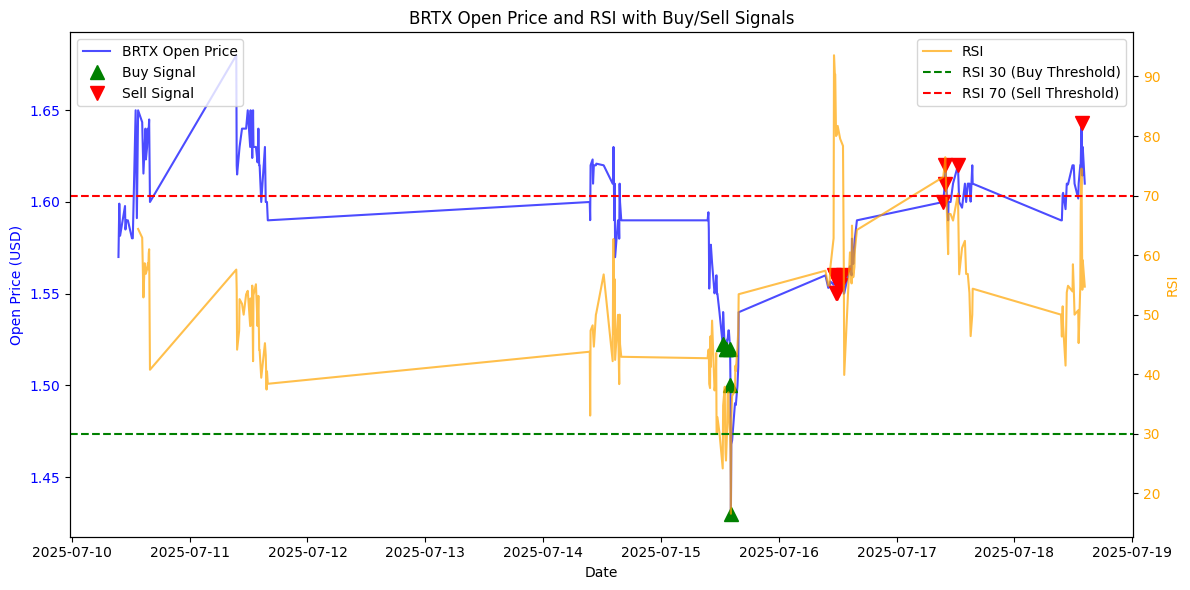

                             Open        RSI Signal
Datetime                                           
2025-07-18 13:30:00-04:00  1.6200  67.688612   Hold
2025-07-18 13:40:00-04:00  1.6428  74.535240   Sell
2025-07-18 13:50:00-04:00  1.6144  54.187195   Hold
2025-07-18 13:55:00-04:00  1.6300  59.150787   Hold
2025-07-18 14:20:00-04:00  1.6100  54.705496   Hold


In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(BRTX_data.index, BRTX_data['Open'], label="BRTX Open Price", color='blue', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Open Price (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1.plot(BRTX_data.index[BRTX_data['Buy_Signal']], BRTX_data['Open'][BRTX_data['Buy_Signal']], '^', markersize=10, color='green', label='Buy Signal')
ax1.plot(BRTX_data.index[BRTX_data['Sell_Signal']], BRTX_data['Open'][BRTX_data['Sell_Signal']], 'v', markersize=10, color='red', label='Sell Signal')

ax2 = ax1.twinx()
ax2.plot(BRTX_data.index, BRTX_data['RSI'], label="RSI", color='orange', alpha=0.7)
ax2.axhline(y=30, color='green', linestyle='--', label='RSI 30 (Buy Threshold)')
ax2.axhline(y=70, color='red', linestyle='--', label='RSI 70 (Sell Threshold)')
ax2.set_ylabel('RSI', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("BRTX Open Price and RSI with Buy/Sell Signals")
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

print(BRTX_data[['Open', 'RSI', 'Signal']].tail())

# Denoised BRTX

In [ ]:
BRTX = yf.Ticker("BRTX")
BRTX_data = BRTX.history(start="2025-07-10", end="2025-07-20", interval = '5m')
BRTX_data = BRTX_data.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
BRTX_data = BRTX_data[BRTX_data.Open != BRTX_data.Close]
BRTX_data = BRTX_data.reset_index()

def moving_average_filter(data, window_size):
    window = np.ones(window_size) / float(window_size)
    convolved_data = np.convolve(data, window, 'same')
    print("Original data: {}".format(data[:10]))
    print("Moving average filtered data with window size {}: {}".format(window_size, convolved_data[:10]))
    return convolved_data

window_size = 4
open_prices = BRTX_data['Open'].values
denoised_open = moving_average_filter(open_prices, window_size)
BRTX_data['Denoised_Open'] = denoised_open
print(BRTX_data[['Open', 'Denoised_Open']].head(10))


Original data: [1.59909999 1.59780002 1.58019996 1.64349997 1.63999999 1.62709999
 1.63499999 1.64999998 1.62       1.62      ]
Moving average filtered data with window size 4: [0.799225   1.19427499 1.60514998 1.61537498 1.62269998 1.63639998
 1.63802499 1.63302499 1.63124999 1.62      ]
     Open  Denoised_Open
0  1.5991       0.799225
1  1.5978       1.194275
2  1.5802       1.605150
3  1.6435       1.615375
4  1.6400       1.622700
5  1.6271       1.636400
6  1.6350       1.638025
7  1.6500       1.633025
8  1.6200       1.631250
9  1.6200       1.620000


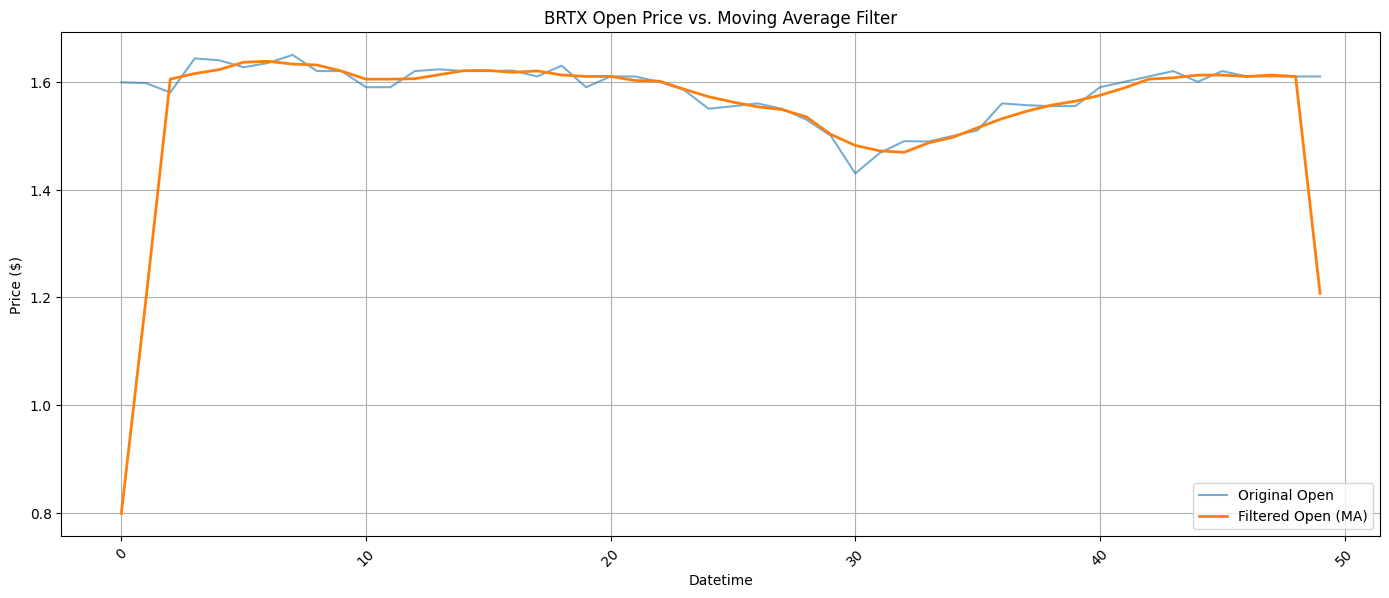

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(BRTX_data.index, BRTX_data['Open'], label='Original Open', alpha=0.6)
plt.plot(BRTX_data.index, BRTX_data['Denoised_Open'], label='Filtered Open (MA)', linewidth=2)

plt.title('BRTX Open Price vs. Moving Average Filter')
plt.xlabel('Datetime')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [ ]:
gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.15,
                                 random_state=42, max_features=2)
gbc.fit(X_train_2d, y_train)
gbc_proba = gbc.predict_proba(X_test_2d)[:, 1]
gbc_preds = gbc.predict(X_test_2d)
gbc_acc = accuracy_score(y_test, gbc_preds)
print("Gradient Boosting Accuracy:", gbc_acc)


Gradient Boosting Accuracy: 0.5294117647058824


In [ ]:
rf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=42)
rf.fit(X_train_2d, y_train)
rf_proba = rf.predict_proba(X_test_2d)[:, 1]
rf_preds = rf.predict(X_test_2d)
rf_acc = accuracy_score(y_test, rf_preds)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 0.47058823529411764


In [ ]:
Open_df = pd.DataFrame({'Open': Open})
Open_df['Shift1'] = Open_df['Open'].shift(1)
Open_df['Shift2'] = Open_df['Open'].shift(2)
Open_df['Shift3'] = Open_df['Open'].shift(3)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_3d, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_proba = model.predict(X_test_3d).ravel()
lstm_acc = model.evaluate(X_test_3d, y_test, verbose=0)[1]
print("LSTM Accuracy:", lstm_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
LSTM Accuracy: 0.5882353186607361


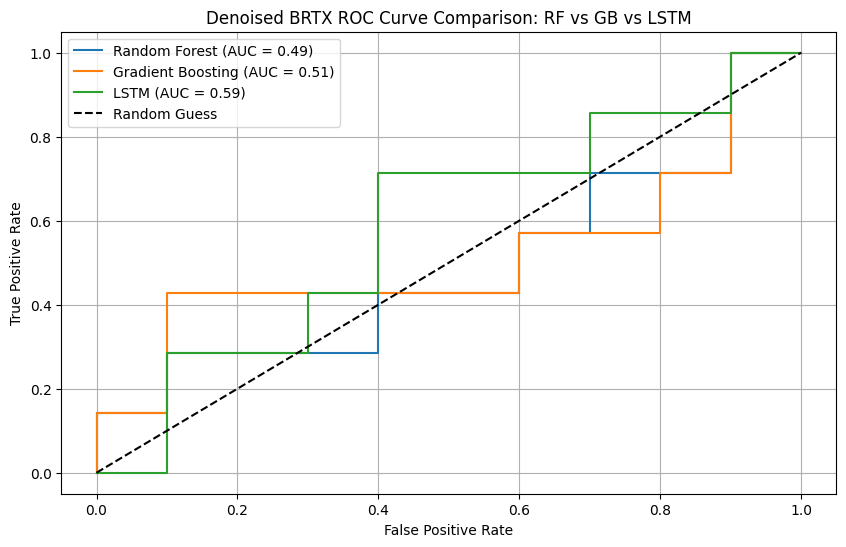

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, gbc_proba)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_proba)

auc_rf = auc(fpr_rf, tpr_rf)
auc_gbc = auc(fpr_gbc, tpr_gbc)
auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_gbc, tpr_gbc, label=f'Gradient Boosting (AUC = {auc_gbc:.2f})')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Denoised BRTX ROC Curve Comparison: RF vs GB vs LSTM')
plt.legend()
plt.grid(True)
plt.show()

# NEGG Stock Test

In [ ]:
NEGG = yf.Ticker("NEGG")
NEGG_data = NEGG.history(start="2025-08-04", end="2025-08-05", interval = '1m')
NEGG_data = NEGG_data.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
NEGG_data.drop('Volume', axis = 1, inplace=True)

NEGG_data.index = NEGG_data.index.tz_convert('US/Eastern')

NEGG_data = NEGG_data[NEGG_data.Open != NEGG_data.Close]

start_time = pd.Timestamp("2025-08-04 09:30:00", tz="US/Eastern")
end_time = pd.Timestamp("2025-08-04 13:00:00", tz="US/Eastern")
NEGG_data = NEGG_data[(NEGG_data.index >= start_time) & (NEGG_data.index <= end_time)]

NEGG_data = NEGG_data.reset_index()

NEGG_data.head(10)
NEGG_data.tail(10)

,Datetime,Open,High,Low,Close,Dividends,Stock Splits
138,2025-08-04 12:30:00-04:00,55.181599,55.200001,54.855000,54.855000,0.0,0.0
139,2025-08-04 12:32:00-04:00,54.500099,55.144600,54.500099,55.144600,0.0,0.0
140,2025-08-04 12:35:00-04:00,55.200001,55.270000,55.200001,55.270000,0.0,0.0
141,2025-08-04 12:36:00-04:00,55.450001,55.525002,55.209999,55.490002,0.0,0.0
142,2025-08-04 12:37:00-04:00,54.990002,54.990002,54.980000,54.980000,0.0,0.0
143,2025-08-04 12:44:00-04:00,55.365002,55.395000,55.365002,55.395000,0.0,0.0
144,2025-08-04 12:45:00-04:00,55.395000,55.709999,55.395000,55.709999,0.0,0.0
145,2025-08-04 12:51:00-04:00,55.220001,55.250000,55.220001,55.250000,0.0,0.0
146,2025-08-04 12:56:00-04:00,55.459999,55.471199,55.459999,55.471199,0.0,0.0
147,2025-08-04 12:57:00-04:00,55.455002,55.455002,55.205101,55.205101,0.0,0.0


In [ ]:
Open = NEGG_data["Open"].reset_index(drop=True)
total_size = len(Open)

train_end = int(0.7 * total_size)
val_end = int(0.9 * total_size)

train = Open.iloc[:train_end]
valid = Open.iloc[train_end:val_end]
test = Open.iloc[val_end:]

def create_features_targets(open_series):
    df = pd.DataFrame({'Open': open_series})
    df['Shift1'] = df['Open'].shift(1)
    df['Shift2'] = df['Open'].shift(2)
    df['Shift3'] = df['Open'].shift(3)
    df['Target'] = (df['Open'].shift(-1) > df['Open']).astype(int)
    df.dropna(inplace=True)
    return df[['Shift1', 'Shift2', 'Shift3']], df['Target']

full_df = pd.DataFrame({'Open': Open})
full_df['Shift1'] = full_df['Open'].shift(1)
full_df['Shift2'] = full_df['Open'].shift(2)
full_df['Shift3'] = full_df['Open'].shift(3)
full_df['Target'] = (full_df['Open'].shift(-1) > full_df['Open']).astype(int)
full_df.dropna(inplace=True)

full_df.reset_index(drop=True, inplace=True)

total_size = len(full_df)
train_end = int(0.7 * total_size)
val_end = int(0.9 * total_size)

train_df = full_df.iloc[:train_end]
valid_df = full_df.iloc[train_end:val_end]
test_df  = full_df.iloc[val_end:]

X_train, y_train = train_df[['Shift1', 'Shift2', 'Shift3']], train_df['Target']
X_valid, y_valid = valid_df[['Shift1', 'Shift2', 'Shift3']], valid_df['Target']
X_test, y_test   = test_df[['Shift1', 'Shift2', 'Shift3']], test_df['Target']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)
X_train_2d, X_test_2d = X_train_scaled.copy(), X_test_scaled.copy()
X_train_3d = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_3d  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.15,
                                 random_state=40, max_features=2)
gbc.fit(X_train_2d, y_train)
gbc_proba = gbc.predict_proba(X_test_2d)[:, 1]
gbc_preds = gbc.predict(X_test_2d)
gbc_acc = accuracy_score(y_test, gbc_preds)
print("Gradient Boosting Accuracy:", gbc_acc)

rf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=30)
rf.fit(X_train_2d, y_train)
rf_proba = rf.predict_proba(X_test_2d)[:, 1]
rf_preds = rf.predict(X_test_2d)
rf_acc = accuracy_score(y_test, rf_preds)
print("Random Forest Accuracy:", rf_acc)

Open_df = pd.DataFrame({'Open': Open})
Open_df['Shift1'] = Open_df['Open'].shift(1)
Open_df['Shift2'] = Open_df['Open'].shift(2)
Open_df['Shift3'] = Open_df['Open'].shift(3)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_3d, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_proba = model.predict(X_test_3d).ravel()
lstm_acc = model.evaluate(X_test_3d, y_test, verbose=0)[1]
print("LSTM Accuracy:", lstm_acc)

Gradient Boosting Accuracy: 0.6
Random Forest Accuracy: 0.6666666666666666


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
LSTM Accuracy: 0.6000000238418579


In [ ]:
change_NEGG = NEGG_data['Open'].diff()
gain_NEGG = change_NEGG.where(change_NEGG > 0, 0)
loss_NEGG = -change_NEGG.where(change_NEGG < 0, 0)
avg_gain_NEGG  = gain_NEGG.rolling(window=14).mean()
avg_loss_NEGG = loss_NEGG.rolling(window=14).mean()
rsi_NEGG = avg_gain_NEGG / avg_loss_NEGG
NEGG_data['RSI'] = 100 - (100 / (1 + rsi_NEGG))
rsi_NEGG.dropna(inplace=True)
rsi_NEGG.head()

X_train_2d = pd.DataFrame(X_train_2d)
X_test_2d = pd.DataFrame(X_test_2d)
X_train_2d.columns = X_train_2d.columns.astype(str)
X_test_2d.columns = X_test_2d.columns.astype(str)
X_train_2d['RSI'] = rsi_NEGG.iloc[:len(X_train_2d)].values
X_test_2d['RSI'] = rsi_NEGG.iloc[len(X_train_2d):len(X_train_2d)+len(X_test_2d)].values
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.07, random_state=40, max_features=2)
gbc.fit(X_train_scaled, y_train)

NEGG_gbc_proba_rsi = gbc.predict_proba(X_test_scaled)[:, 1]
NEGG_gbc_preds_rsi = gbc.predict(X_test_scaled)
NEGG_gbc_acc_rsi = accuracy_score(y_test, NEGG_gbc_preds_rsi)

print("NEGG Gradient Boosting Accuracy with RSI:", NEGG_gbc_acc_rsi)
print("NEGG Gradient Boosting Accuracy without RSI", gbc_acc)


NEGG Gradient Boosting Accuracy with RSI: 0.6
NEGG Gradient Boosting Accuracy without RSI 0.6


In [ ]:
NEGG_Money = Money('1000000.00', 'USD')
Initial_Investment = NEGG_Money.amount
Shares = 0
Portfolio_value = Initial_Investment
buy_threshold = 30
sell_threshold = 70
Trade_log = []

NEGG_data['Buy_Signal'] = (NEGG_data['RSI'] < buy_threshold)
NEGG_data['Sell_Signal'] = (NEGG_data['RSI'] > sell_threshold)

NEGG_data['Signal'] = 'Hold'
NEGG_data.loc[NEGG_data['Buy_Signal'], 'Signal'] = 'Buy'
NEGG_data.loc[NEGG_data['Sell_Signal'], 'Signal'] = 'Sell'

for i in range(1, len(NEGG_data)):
    current_date = NEGG_data.index[i]
    current_rsi = NEGG_data['RSI'].iloc[i]
    current_open = NEGG_data['Open'].iloc[i]
    current_open_decimal = Decimal(str(current_open))

    if current_rsi < buy_threshold and NEGG_Money.amount >= current_open_decimal:
        num_shares_to_buy = int(NEGG_Money.amount // current_open_decimal)
        if num_shares_to_buy > 0:
            new_amount = NEGG_Money.amount - (num_shares_to_buy * current_open_decimal)
            NEGG_Money = Money(str(new_amount), 'USD')
            Shares += num_shares_to_buy
            Trade_log.append(f"{current_date}: Bought {num_shares_to_buy} shares at {current_open_decimal:.2f} USD")

    elif current_rsi > sell_threshold and Shares > 0:
        new_amount = NEGG_Money.amount + (Shares * current_open_decimal)
        NEGG_Money = Money(str(new_amount), 'USD')
        Trade_log.append(f"{current_date}: Sold {Shares} shares at {current_open_decimal:.2f} USD")
        Shares = 0

    Portfolio_value = NEGG_Money.amount + (Shares * current_open_decimal)



final_value = Portfolio_value
total_return = final_value - Initial_Investment
total_percentage_return = (total_return / Initial_Investment) * 100

print(f"Final Portfolio Value: {final_value:,.2f} USD")
print(f"Total Return: {total_return:,.2f} USD")
print(f"Total Percentage Return: {total_percentage_return:.2f}%")

for trade in Trade_log:
    print(trade)



Final Portfolio Value: 918,818.19 USD
Total Return: -81,181.81 USD
Total Percentage Return: -8.12%
45: Bought 16164 shares at 61.87 USD
104: Sold 16164 shares at 55.51 USD
127: Bought 16568 shares at 54.15 USD


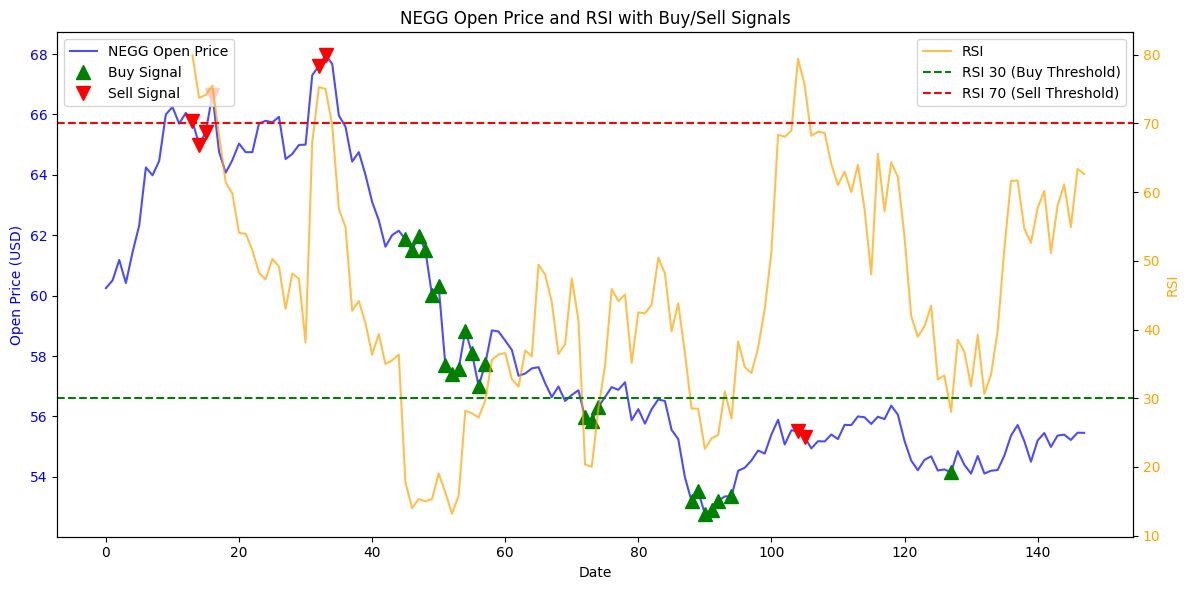

          Open        RSI Signal
143  55.365002  58.006143   Hold
144  55.395000  61.122804   Hold
145  55.220001  54.915629   Hold
146  55.459999  63.380011   Hold
147  55.455002  62.642579   Hold


In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(NEGG_data.index, NEGG_data['Open'], label="NEGG Open Price", color='blue', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Open Price (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1.plot(NEGG_data.index[NEGG_data['Buy_Signal']], NEGG_data['Open'][NEGG_data['Buy_Signal']], '^', markersize=10, color='green', label='Buy Signal')
ax1.plot(NEGG_data.index[NEGG_data['Sell_Signal']], NEGG_data['Open'][NEGG_data['Sell_Signal']], 'v', markersize=10, color='red', label='Sell Signal')

ax2 = ax1.twinx()
ax2.plot(NEGG_data.index, NEGG_data['RSI'], label="RSI", color='orange', alpha=0.7)
ax2.axhline(y=30, color='green', linestyle='--', label='RSI 30 (Buy Threshold)')
ax2.axhline(y=70, color='red', linestyle='--', label='RSI 70 (Sell Threshold)')
ax2.set_ylabel('RSI', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("NEGG Open Price and RSI with Buy/Sell Signals")
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()


print(NEGG_data[['Open', 'RSI', 'Signal']].tail())

In [ ]:
NEGG = yf.Ticker("NEGG")
NEGG_data = NEGG.history(start="2025-08-04", end="2025-08-05", interval = '1m')
NEGG_data = NEGG_data.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
NEGG_data.drop('Volume', axis = 1, inplace=True)

NEGG_data.index = NEGG_data.index.tz_convert('US/Eastern')

NEGG_data = NEGG_data[NEGG_data.Open != NEGG_data.Close]

start_time = pd.Timestamp("2025-08-04 09:30:00", tz="US/Eastern")
end_time = pd.Timestamp("2025-08-04 13:00:00", tz="US/Eastern")
NEGG_data = NEGG_data[(NEGG_data.index >= start_time) & (NEGG_data.index <= end_time)]

NEGG_data = NEGG_data.reset_index()

def moving_average_filter(data, window_size):
    window = np.ones(window_size) / float(window_size)
    convolved_data = np.convolve(data, window, 'same')
    print("Original data: {}".format(data[:10]))
    print("Moving average filtered data with window size {}: {}".format(window_size, convolved_data[:10]))
    return convolved_data

window_size = 4

open_prices = NEGG_data['Open'].values
denoised_open = moving_average_filter(open_prices, window_size)
NEGG_data['Denoised_Open'] = denoised_open
print(NEGG_data[['Datetime', 'Open', 'Denoised_Open']].head(10))

change_NEGG = NEGG_data['Denoised_Open'].diff()
gain_NEGG = change_NEGG.where(change_NEGG > 0, 0)
loss_NEGG = -change_NEGG.where(change_NEGG < 0, 0)
avg_gain_NEGG  = gain_NEGG.rolling(window=14).mean()
avg_loss_NEGG = loss_NEGG.rolling(window=14).mean()

rsi_NEGG = avg_gain_NEGG / (avg_loss_NEGG + 1e-10)

NEGG_data['RSI'] = 100 - (100 / (1 + rsi_NEGG))

buy_threshold = 30
sell_threshold = 70

NEGG_data['Buy_Signal'] = (NEGG_data['RSI'] < buy_threshold)
NEGG_data['Sell_Signal'] = (NEGG_data['RSI'] > sell_threshold)

NEGG_data['Signal'] = 'Hold'
NEGG_data.loc[NEGG_data['Buy_Signal'], 'Signal'] = 'Buy'
NEGG_data.loc[NEGG_data['Sell_Signal'], 'Signal'] = 'Sell'

Original data: [60.25       60.50500107 61.18130112 60.41600037 61.43999863 62.32500076
 64.24500275 63.98519897 64.45999908 66.        ]
Moving average filtered data with window size 4: [30.18875027 45.48407555 60.58807564 60.88557529 61.34057522 62.10650063
 62.99880028 63.75380039 64.6725502  65.1731739 ]
                   Datetime       Open  Denoised_Open
0 2025-08-04 09:30:00-04:00  60.250000      30.188750
1 2025-08-04 09:31:00-04:00  60.505001      45.484076
2 2025-08-04 09:33:00-04:00  61.181301      60.588076
3 2025-08-04 09:34:00-04:00  60.416000      60.885575
4 2025-08-04 09:35:00-04:00  61.439999      61.340575
5 2025-08-04 09:36:00-04:00  62.325001      62.106501
6 2025-08-04 09:37:00-04:00  64.245003      62.998800
7 2025-08-04 09:38:00-04:00  63.985199      63.753800
8 2025-08-04 09:39:00-04:00  64.459999      64.672550
9 2025-08-04 09:40:00-04:00  66.000000      65.173174


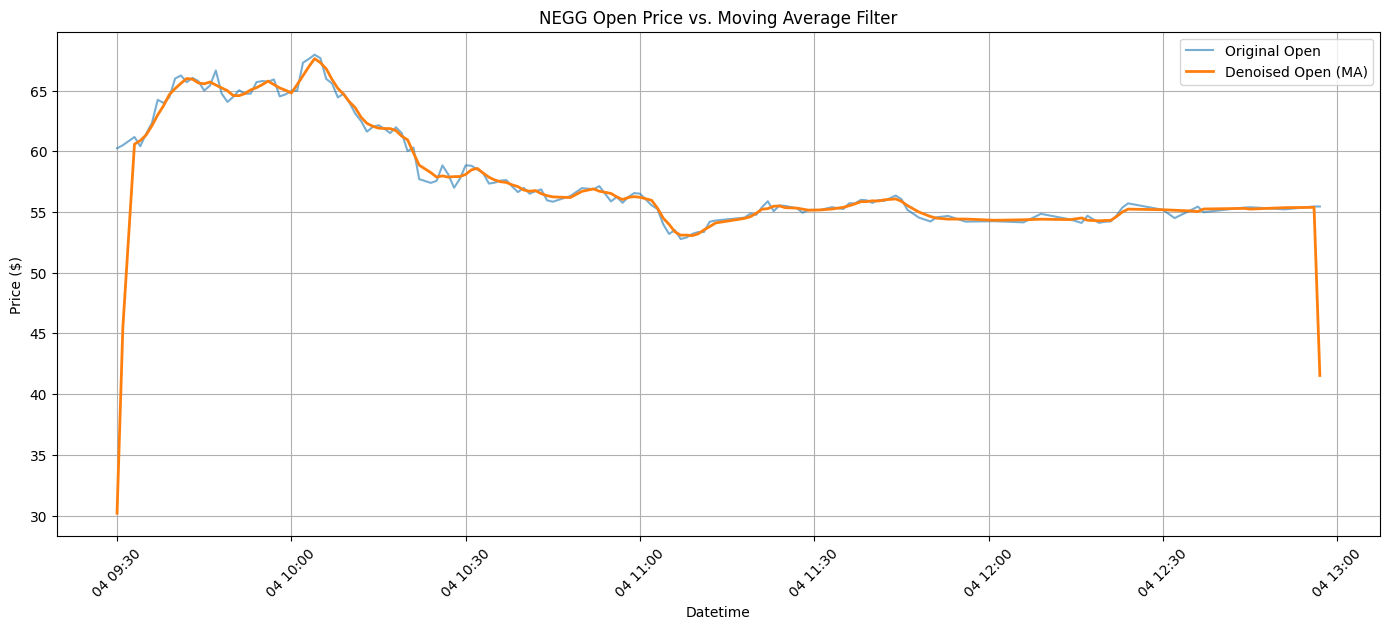

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(NEGG_data['Datetime'], NEGG_data['Open'], label='Original Open', alpha=0.6)
plt.plot(NEGG_data['Datetime'], NEGG_data['Denoised_Open'], label='Denoised Open (MA)', linewidth=2)

plt.title('NEGG Open Price vs. Moving Average Filter')
plt.xlabel('Datetime')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [ ]:
gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.15,
                                 random_state=40, max_features=2)
gbc.fit(X_train_2d, y_train)
gbc_proba = gbc.predict_proba(X_test_2d)[:, 1]
gbc_preds = gbc.predict(X_test_2d)
gbc_acc = accuracy_score(y_test, gbc_preds)
print("Gradient Boosting Accuracy:", gbc_acc)

Gradient Boosting Accuracy: 0.7333333333333333


In [ ]:
rf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=30)
rf.fit(X_train_2d, y_train)
rf_proba = rf.predict_proba(X_test_2d)[:, 1]
rf_preds = rf.predict(X_test_2d)
rf_acc = accuracy_score(y_test, rf_preds)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 0.6666666666666666


In [ ]:
Open_df = pd.DataFrame({'Denoised_Open': Open})
Open_df['Shift1'] = Open_df['Denoised_Open'].shift(1)
Open_df['Shift2'] = Open_df['Denoised_Open'].shift(2)
Open_df['Shift3'] = Open_df['Denoised_Open'].shift(3)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_3d, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_proba = model.predict(X_test_3d).ravel()
lstm_acc = model.evaluate(X_test_3d, y_test, verbose=0)[1]
print("LSTM Accuracy:", lstm_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
LSTM Accuracy: 0.6000000238418579


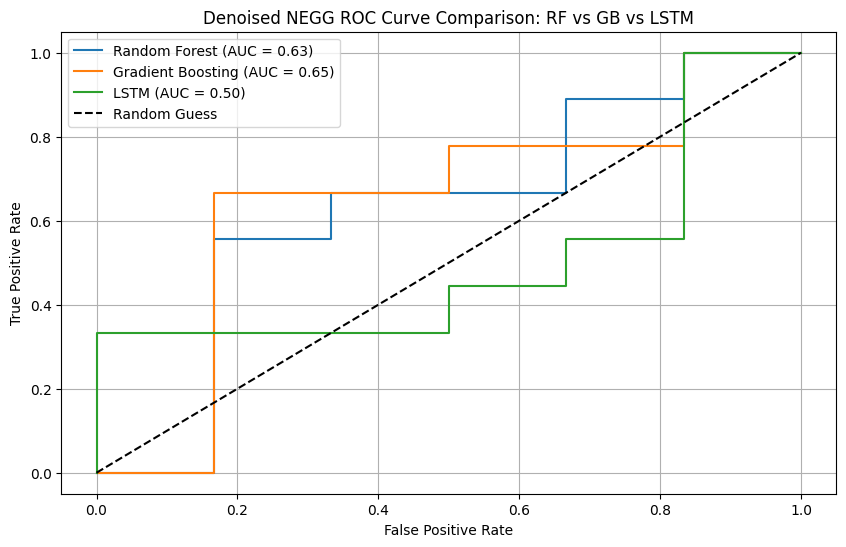

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, gbc_proba)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_proba)

auc_rf = auc(fpr_rf, tpr_rf)
auc_gbc = auc(fpr_gbc, tpr_gbc)
auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_gbc, tpr_gbc, label=f'Gradient Boosting (AUC = {auc_gbc:.2f})')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Denoised NEGG ROC Curve Comparison: RF vs GB vs LSTM')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
change_NEGG = NEGG_data['Denoised_Open'].diff()
gain_NEGG = change_NEGG.where(change_NEGG > 0, 0)
loss_NEGG = -change_NEGG.where(change_NEGG < 0, 0)
avg_gain_NEGG  = gain_NEGG.rolling(window=14).mean()
avg_loss_NEGG = loss_NEGG.rolling(window=14).mean()

rsi_NEGG = avg_gain_NEGG / (avg_loss_NEGG + 1e-10)

NEGG_data['RSI'] = 100 - (100 / (1 + rsi_NEGG))

NEGG_data.replace([np.inf, -np.inf], np.nan, inplace=True)
NEGG_data.dropna(inplace=True)

full_df_cleaned = NEGG_data[['Denoised_Open']].copy()
full_df_cleaned['Shift1'] = full_df_cleaned['Denoised_Open'].shift(1)
full_df_cleaned['Shift2'] = full_df_cleaned['Denoised_Open'].shift(2)
full_df_cleaned['Shift3'] = full_df_cleaned['Denoised_Open'].shift(3)
full_df_cleaned['Target'] = (full_df_cleaned['Denoised_Open'].shift(-1) > full_df_cleaned['Denoised_Open']).astype(int)
full_df_cleaned.dropna(inplace=True)

total_size_cleaned = len(full_df_cleaned)
train_end_cleaned = int(0.7 * total_size_cleaned)
val_end_cleaned = int(0.9 * total_size_cleaned)

train_df_cleaned = full_df_cleaned.iloc[:train_end_cleaned]
test_df_cleaned  = full_df_cleaned.iloc[val_end_cleaned:]

X_train_cleaned = train_df_cleaned[['Shift1', 'Shift2', 'Shift3']]
y_train_cleaned = train_df_cleaned['Target']
X_test_cleaned   = test_df_cleaned[['Shift1', 'Shift2', 'Shift3']]
y_test_cleaned   = test_df_cleaned['Target']


X_train_cleaned['RSI'] = NEGG_data.loc[X_train_cleaned.index, 'RSI']
X_test_cleaned['RSI'] = NEGG_data.loc[X_test_cleaned.index, 'RSI']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_cleaned)
X_test_scaled = scaler.transform(X_test_cleaned)

X_train_2d = pd.DataFrame(X_train_scaled, columns=X_train_cleaned.columns)
X_test_2d = pd.DataFrame(X_test_scaled, columns=X_test_cleaned.columns)


gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.07, random_state=40, max_features=2)
gbc.fit(X_train_scaled, y_train_cleaned)

NEGG_gbc_proba_rsi = gbc.predict_proba(X_test_scaled)[:, 1]
NEGG_gbc_preds_rsi = gbc.predict(X_test_scaled)
NEGG_gbc_acc_rsi = accuracy_score(y_test_cleaned, NEGG_gbc_preds_rsi)

print("NEGG Gradient Boosting Accuracy with RSI:", NEGG_gbc_acc_rsi)


/tmp/ipython-input-783244277.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_cleaned['RSI'] = NEGG_data.loc[X_train_cleaned.index, 'RSI']
/tmp/ipython-input-783244277.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_cleaned['RSI'] = NEGG_data.loc[X_test_cleaned.index, 'RSI']


NEGG Gradient Boosting Accuracy with RSI: 0.5714285714285714


In [ ]:
NEGG_Money = Money('1000000.00', 'USD')
Initial_Investment = NEGG_Money.amount
Shares = 0
Portfolio_value = Initial_Investment
buy_threshold = 30
sell_threshold = 70
Trade_log = []

NEGG_data['Buy_Signal'] = (NEGG_data['RSI'] < buy_threshold)
NEGG_data['Sell_Signal'] = (NEGG_data['RSI'] > sell_threshold)

NEGG_data['Signal'] = 'Hold'
NEGG_data.loc[NEGG_data['Buy_Signal'], 'Signal'] = 'Buy'
NEGG_data.loc[NEGG_data['Sell_Signal'], 'Signal'] = 'Sell'

for i in range(1, len(NEGG_data)):
    current_date = NEGG_data.index[i]
    current_rsi = NEGG_data['RSI'].iloc[i]
    current_open = NEGG_data['Denoised_Open'].iloc[i]
    current_open_decimal = Decimal(str(current_open))

    if current_rsi < buy_threshold and NEGG_Money.amount >= current_open_decimal:
        num_shares_to_buy = int(NEGG_Money.amount // current_open_decimal)
        if num_shares_to_buy > 0:
            new_amount = NEGG_Money.amount - (num_shares_to_buy * current_open_decimal)
            NEGG_Money = Money(str(new_amount), 'USD')
            Shares += num_shares_to_buy
            Trade_log.append(f"{current_date}: Bought {num_shares_to_buy} shares at {current_open_decimal:.2f} USD")

    elif current_rsi > sell_threshold and Shares > 0:
        new_amount = NEGG_Money.amount + (Shares * current_open_decimal)
        NEGG_Money = Money(str(new_amount), 'USD')
        Trade_log.append(f"{current_date}: Sold {Shares} shares at {current_open_decimal:.2f} USD")
        Shares = 0

    Portfolio_value = NEGG_Money.amount + (Shares * current_open_decimal)



final_value = Portfolio_value
total_return = final_value - Initial_Investment
total_percentage_return = (total_return / Initial_Investment) * 100

print(f"Final Portfolio Value: {final_value:,.2f} USD")
print(f"Total Return: {total_return:,.2f} USD")
print(f"Total Percentage Return: {total_percentage_return:.2f}%")

for trade in Trade_log:
    print(trade)



Final Portfolio Value: 909,618.54 USD
Total Return: -90,381.46 USD
Total Percentage Return: -9.04%
44: Bought 16152 shares at 61.91 USD
102: Sold 16152 shares at 55.48 USD
124: Bought 16466 shares at 54.42 USD
137: Sold 16466 shares at 55.24 USD
147: Bought 21900 shares at 41.53 USD


# SEAT Stock Test

In [ ]:
SEAT = yf.Ticker("SEAT")
SEAT_data = SEAT.history(start="2025-08-06", end="2025-08-07", interval = '1m')
SEAT_data = SEAT_data.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
SEAT_data.drop('Volume', axis = 1, inplace=True)

SEAT_data = SEAT_data[SEAT_data.Open != SEAT_data.Close]

SEAT_data.index = SEAT_data.index.tz_convert('US/Eastern')

start_time = pd.Timestamp("2025-08-06 09:30:00", tz="US/Eastern")
end_time = pd.Timestamp("2025-08-06 13:25:00", tz="US/Eastern")
SEAT_data = SEAT_data[(SEAT_data.index >= start_time) & (SEAT_data.index <= end_time)]

SEAT_data = SEAT_data.reset_index()

SEAT_data.head(10)
SEAT_data.tail(10)

,Datetime,Open,High,Low,Close,Dividends,Stock Splits
134,2025-08-06 13:16:00-04:00,31.904400,31.980000,31.799999,31.980000,0.0,0.0
135,2025-08-06 13:17:00-04:00,32.249901,32.953098,32.130001,32.500099,0.0,0.0
136,2025-08-06 13:18:00-04:00,32.685501,33.410000,32.610001,33.260700,0.0,0.0
137,2025-08-06 13:19:00-04:00,33.189999,34.969898,33.189999,34.900002,0.0,0.0
138,2025-08-06 13:20:00-04:00,34.898998,35.000000,34.000000,34.480000,0.0,0.0
139,2025-08-06 13:21:00-04:00,34.180000,34.696201,33.520100,34.485001,0.0,0.0
140,2025-08-06 13:22:00-04:00,34.577999,34.577999,34.000099,34.490002,0.0,0.0
141,2025-08-06 13:23:00-04:00,34.599998,34.799999,34.000099,34.009998,0.0,0.0
142,2025-08-06 13:24:00-04:00,34.199902,34.199902,33.520000,33.900002,0.0,0.0
143,2025-08-06 13:25:00-04:00,33.950001,34.259998,33.545799,33.989899,0.0,0.0


In [ ]:
Open = SEAT_data["Open"].reset_index(drop=True)
total_size = len(Open)

train_end = int(0.7 * total_size)
val_end = int(0.9 * total_size)

train = Open.iloc[:train_end]
valid = Open.iloc[train_end:val_end]
test = Open.iloc[val_end:]

def create_features_targets(open_series):
    df = pd.DataFrame({'Open': open_series})
    df['Shift1'] = df['Open'].shift(1)
    df['Shift2'] = df['Open'].shift(2)
    df['Shift3'] = df['Open'].shift(3)
    df['Target'] = (df['Open'].shift(-1) > df['Open']).astype(int)
    df.dropna(inplace=True)
    return df[['Shift1', 'Shift2', 'Shift3']], df['Target']

full_df = pd.DataFrame({'Open': Open})
full_df['Shift1'] = full_df['Open'].shift(1)
full_df['Shift2'] = full_df['Open'].shift(2)
full_df['Shift3'] = full_df['Open'].shift(3)
full_df['Target'] = (full_df['Open'].shift(-1) > full_df['Open']).astype(int)
full_df.dropna(inplace=True)

full_df.reset_index(drop=True, inplace=True)

total_size = len(full_df)
train_end = int(0.7 * total_size)
val_end = int(0.9 * total_size)

train_df = full_df.iloc[:train_end]
valid_df = full_df.iloc[train_end:val_end]
test_df  = full_df.iloc[val_end:]

X_train, y_train = train_df[['Shift1', 'Shift2', 'Shift3']], train_df['Target']
X_valid, y_valid = valid_df[['Shift1', 'Shift2', 'Shift3']], valid_df['Target']
X_test, y_test   = test_df[['Shift1', 'Shift2', 'Shift3']], test_df['Target']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)
X_train_2d, X_test_2d = X_train_scaled.copy(), X_test_scaled.copy()
X_train_3d = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_3d  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.15,
                                 random_state=40, max_features=2)
gbc.fit(X_train_2d, y_train)
gbc_proba = gbc.predict_proba(X_test_2d)[:, 1]
gbc_preds = gbc.predict(X_test_2d)
gbc_acc = accuracy_score(y_test, gbc_preds)
print("Gradient Boosting Accuracy:", gbc_acc)

rf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=30)
rf.fit(X_train_2d, y_train)
rf_proba = rf.predict_proba(X_test_2d)[:, 1]
rf_preds = rf.predict(X_test_2d)
rf_acc = accuracy_score(y_test, rf_preds)
print("Random Forest Accuracy:", rf_acc)

Open_df = pd.DataFrame({'Open': Open})
Open_df['Shift1'] = Open_df['Open'].shift(1)
Open_df['Shift2'] = Open_df['Open'].shift(2)
Open_df['Shift3'] = Open_df['Open'].shift(3)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_3d, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_proba = model.predict(X_test_3d).ravel()
lstm_acc = model.evaluate(X_test_3d, y_test, verbose=0)[1]
print("LSTM Accuracy:", lstm_acc)

Gradient Boosting Accuracy: 0.5333333333333333
Random Forest Accuracy: 0.5333333333333333


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
LSTM Accuracy: 0.46666666865348816


In [ ]:
change_SEAT = SEAT_data['Open'].diff()
gain_SEAT = change_SEAT.where(change_SEAT > 0, 0)
loss_SEAT = -change_SEAT.where(change_SEAT < 0, 0)
avg_gain_SEAT  = gain_SEAT.rolling(window=14).mean()
avg_loss_SEAT = loss_SEAT.rolling(window=14).mean()
rsi_SEAT = avg_gain_SEAT / avg_loss_SEAT
SEAT_data['RSI'] = 100 - (100 / (1 + rsi_SEAT))
rsi_SEAT.dropna(inplace=True)
rsi_SEAT.head()

X_train_2d = pd.DataFrame(X_train_2d)
X_test_2d = pd.DataFrame(X_test_2d)
X_train_2d.columns = X_train_2d.columns.astype(str)
X_test_2d.columns = X_test_2d.columns.astype(str)
X_train_2d['RSI'] = rsi_SEAT.iloc[:len(X_train_2d)].values
X_test_2d['RSI'] = rsi_SEAT.iloc[len(X_train_2d):len(X_train_2d)+len(X_test_2d)].values
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.07, random_state=40, max_features=2)
gbc.fit(X_train_scaled, y_train)

SEAT_gbc_proba_rsi = gbc.predict_proba(X_test_scaled)[:, 1]
SEAT_gbc_preds_rsi = gbc.predict(X_test_scaled)
SEAT_gbc_acc_rsi = accuracy_score(y_test, SEAT_gbc_preds_rsi)

print("SEAT Gradient Boosting Accuracy with RSI:", SEAT_gbc_acc_rsi)
print("SEAT Gradient Boosting Accuracy without RSI", gbc_acc)


SEAT Gradient Boosting Accuracy with RSI: 0.3333333333333333
SEAT Gradient Boosting Accuracy without RSI 0.5333333333333333


In [ ]:
SEAT_Money = Money('1000000.00', 'USD')
Initial_Investment = SEAT_Money.amount
Shares = 0
Portfolio_value = Initial_Investment
buy_threshold = 30
sell_threshold = 70
Trade_log = []

SEAT_data['Buy_Signal'] = (SEAT_data['RSI'] < buy_threshold)
SEAT_data['Sell_Signal'] = (SEAT_data['RSI'] > sell_threshold)

SEAT_data['Signal'] = 'Hold'
SEAT_data.loc[SEAT_data['Buy_Signal'], 'Signal'] = 'Buy'
SEAT_data.loc[SEAT_data['Sell_Signal'], 'Signal'] = 'Sell'

for i in range(1, len(SEAT_data)):
    current_date = SEAT_data.index[i]
    current_rsi = SEAT_data['RSI'].iloc[i]
    current_open = SEAT_data['Open'].iloc[i]
    current_open_decimal = Decimal(str(current_open))

    if current_rsi < buy_threshold and SEAT_Money.amount >= current_open_decimal:
        num_shares_to_buy = int(SEAT_Money.amount // current_open_decimal)
        if num_shares_to_buy > 0:
            new_amount = SEAT_Money.amount - (num_shares_to_buy * current_open_decimal)
            SEAT_Money = Money(str(new_amount), 'USD')
            Shares += num_shares_to_buy
            Trade_log.append(f"{current_date}: Bought {num_shares_to_buy} shares at {current_open_decimal:.2f} USD")

    elif current_rsi > sell_threshold and Shares > 0:
        new_amount = SEAT_Money.amount + (Shares * current_open_decimal)
        SEAT_Money = Money(str(new_amount), 'USD')
        Trade_log.append(f"{current_date}: Sold {Shares} shares at {current_open_decimal:.2f} USD")
        Shares = 0

    Portfolio_value = SEAT_Money.amount + (Shares * current_open_decimal)



final_value = Portfolio_value
total_return = final_value - Initial_Investment
total_percentage_return = (total_return / Initial_Investment) * 100

print(f"Final Portfolio Value: {final_value:,.2f} USD")
print(f"Total Return: {total_return:,.2f} USD")
print(f"Total Percentage Return: {total_percentage_return:.2f}%")

for trade in Trade_log:
    print(trade)



Final Portfolio Value: 991,873.57 USD
Total Return: -8,126.43 USD
Total Percentage Return: -0.81%
21: Bought 42771 shares at 23.38 USD
44: Sold 42771 shares at 23.19 USD


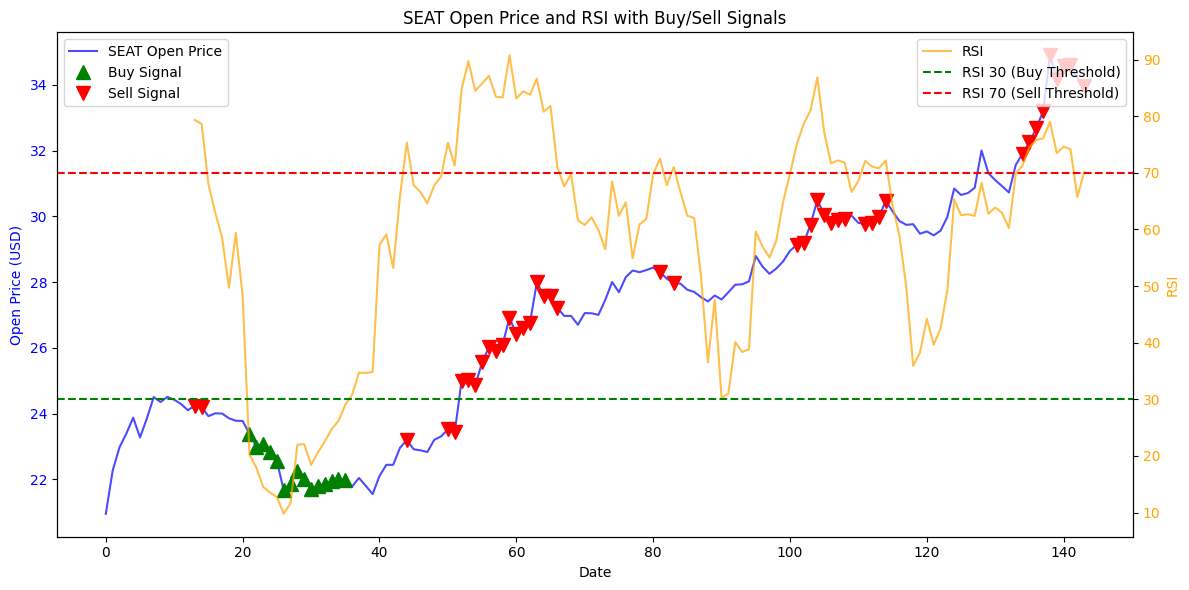

          Open        RSI Signal
139  34.180000  73.477006   Sell
140  34.577999  74.631058   Sell
141  34.599998  74.170994   Sell
142  34.199902  65.740363   Hold
143  33.950001  70.129939   Sell


In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(SEAT_data.index, SEAT_data['Open'], label="SEAT Open Price", color='blue', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Open Price (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1.plot(SEAT_data.index[SEAT_data['Buy_Signal']], SEAT_data['Open'][SEAT_data['Buy_Signal']], '^', markersize=10, color='green', label='Buy Signal')
ax1.plot(SEAT_data.index[SEAT_data['Sell_Signal']], SEAT_data['Open'][SEAT_data['Sell_Signal']], 'v', markersize=10, color='red', label='Sell Signal')

ax2 = ax1.twinx()
ax2.plot(SEAT_data.index, SEAT_data['RSI'], label="RSI", color='orange', alpha=0.7)
ax2.axhline(y=30, color='green', linestyle='--', label='RSI 30 (Buy Threshold)')
ax2.axhline(y=70, color='red', linestyle='--', label='RSI 70 (Sell Threshold)')
ax2.set_ylabel('RSI', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("SEAT Open Price and RSI with Buy/Sell Signals")
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

print(SEAT_data[['Open', 'RSI', 'Signal']].tail())

In [ ]:
SEAT = yf.Ticker("SEAT")
SEAT_data = SEAT.history(start="2025-08-06", end="2025-08-07", interval = '1m')
SEAT_data = SEAT_data.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
SEAT_data.drop('Volume', axis = 1, inplace=True)

SEAT_data = SEAT_data[SEAT_data.Open != SEAT_data.Close]

SEAT_data.index = SEAT_data.index.tz_convert('US/Eastern')

start_time = pd.Timestamp("2025-08-06 09:30:00", tz="US/Eastern")
end_time = pd.Timestamp("2025-08-06 13:25:00", tz="US/Eastern")
SEAT_data = SEAT_data[(SEAT_data.index >= start_time) & (SEAT_data.index <= end_time)]

SEAT_data = SEAT_data.reset_index()

def moving_average_filter(data, window_size):
    window = np.ones(window_size) / float(window_size)
    convolved_data = np.convolve(data, window, 'same')
    print("Original data: {}".format(data[:10]))
    print("Moving average filtered data with window size {}: {}".format(window_size, convolved_data[:10]))
    return convolved_data

window_size = 4

open_prices = SEAT_data['Open'].values
denoised_open = moving_average_filter(open_prices, window_size)
SEAT_data['Denoised_Open'] = denoised_open
print(SEAT_data[['Datetime', 'Open', 'Denoised_Open']].head(10))

change_SEAT = SEAT_data['Denoised_Open'].diff()
gain_SEAT = change_SEAT.where(change_SEAT > 0, 0)
loss_SEAT = -change_SEAT.where(change_SEAT < 0, 0)
avg_gain_SEAT  = gain_SEAT.rolling(window=14).mean()
avg_loss_SEAT = loss_SEAT.rolling(window=14).mean()

rsi_SEAT = avg_gain_SEAT / (avg_loss_SEAT + 1e-10)

SEAT_data['RSI'] = 100 - (100 / (1 + rsi_SEAT))

buy_threshold = 30
sell_threshold = 70

SEAT_data['Buy_Signal'] = (SEAT_data['RSI'] < buy_threshold)
SEAT_data['Sell_Signal'] = (SEAT_data['RSI'] > sell_threshold)

SEAT_data['Signal'] = 'Hold'
SEAT_data.loc[SEAT_data['Buy_Signal'], 'Signal'] = 'Buy'
SEAT_data.loc[SEAT_data['Sell_Signal'], 'Signal'] = 'Sell'

Original data: [20.95000076 22.26000023 22.97270012 23.38999939 23.87380028 23.27070045
 23.85000038 24.50049973 24.35000038 24.50499916]
Moving average filtered data with window size 4: [10.80250025 16.54567528 22.39317513 23.124125   23.37680006 23.59612513
 23.87375021 23.99280024 24.30137491 24.44387484]
                   Datetime       Open  Denoised_Open
0 2025-08-06 09:30:00-04:00  20.950001      10.802500
1 2025-08-06 09:31:00-04:00  22.260000      16.545675
2 2025-08-06 09:33:00-04:00  22.972700      22.393175
3 2025-08-06 09:34:00-04:00  23.389999      23.124125
4 2025-08-06 09:35:00-04:00  23.873800      23.376800
5 2025-08-06 09:36:00-04:00  23.270700      23.596125
6 2025-08-06 09:37:00-04:00  23.850000      23.873750
7 2025-08-06 09:38:00-04:00  24.500500      23.992800
8 2025-08-06 09:39:00-04:00  24.350000      24.301375
9 2025-08-06 09:41:00-04:00  24.504999      24.443875


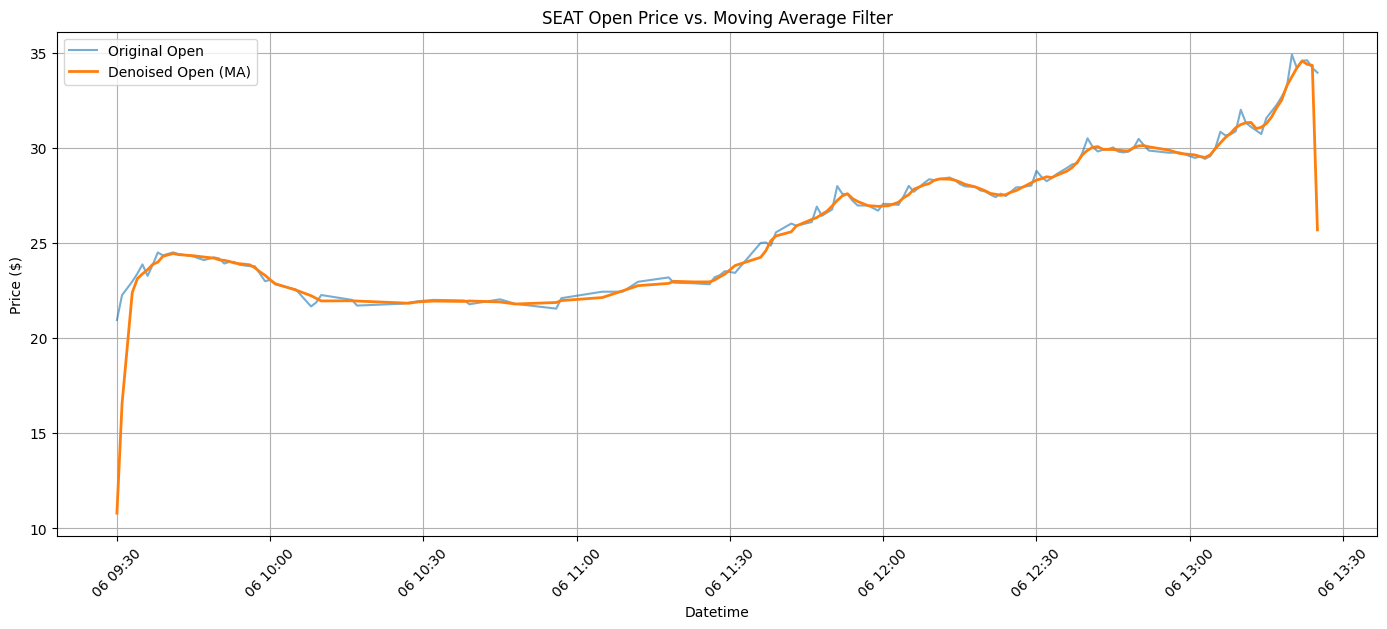

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(SEAT_data['Datetime'], SEAT_data['Open'], label='Original Open', alpha=0.6)
plt.plot(SEAT_data['Datetime'], SEAT_data['Denoised_Open'], label='Denoised Open (MA)', linewidth=2)

plt.title('SEAT Open Price vs. Moving Average Filter')
plt.xlabel('Datetime')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [ ]:
gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.15,
                                 random_state=40, max_features=2)
gbc.fit(X_train_2d, y_train)
gbc_proba = gbc.predict_proba(X_test_2d)[:, 1]
gbc_preds = gbc.predict(X_test_2d)
gbc_acc = accuracy_score(y_test, gbc_preds)
print("Gradient Boosting Accuracy:", gbc_acc)


Gradient Boosting Accuracy: 0.3333333333333333


In [ ]:
rf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=30)
rf.fit(X_train_2d, y_train)
rf_proba = rf.predict_proba(X_test_2d)[:, 1]
rf_preds = rf.predict(X_test_2d)
rf_acc = accuracy_score(y_test, rf_preds)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 0.3333333333333333


In [ ]:
Open_df = pd.DataFrame({'Denoised_Open': Open})
Open_df['Shift1'] = Open_df['Denoised_Open'].shift(1)
Open_df['Shift2'] = Open_df['Denoised_Open'].shift(2)
Open_df['Shift3'] = Open_df['Denoised_Open'].shift(3)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_3d, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_proba = model.predict(X_test_3d).ravel()
lstm_acc = model.evaluate(X_test_3d, y_test, verbose=0)[1]
print("LSTM Accuracy:", lstm_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
LSTM Accuracy: 0.46666666865348816


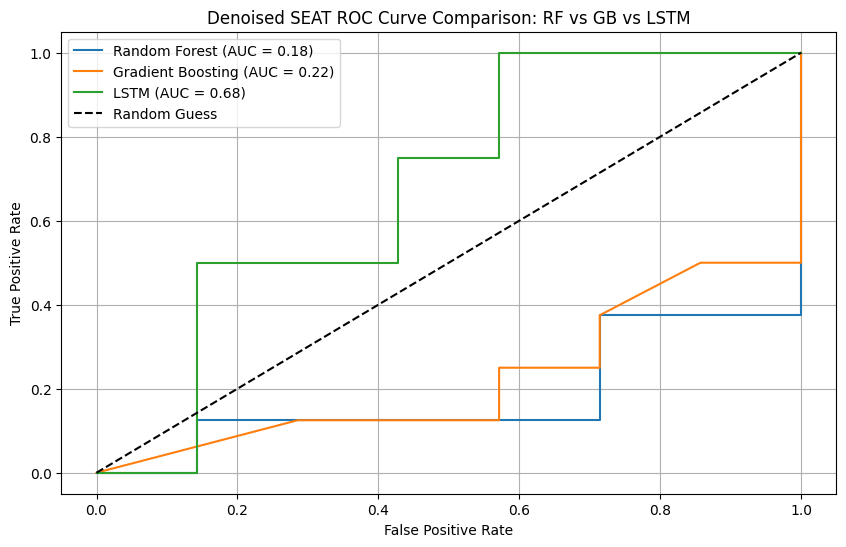

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, gbc_proba)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_proba)

auc_rf = auc(fpr_rf, tpr_rf)
auc_gbc = auc(fpr_gbc, tpr_gbc)
auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_gbc, tpr_gbc, label=f'Gradient Boosting (AUC = {auc_gbc:.2f})')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Denoised SEAT ROC Curve Comparison: RF vs GB vs LSTM')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
change_SEAT = SEAT_data['Denoised_Open'].diff()
gain_SEAT = change_SEAT.where(change_SEAT > 0, 0)
loss_SEAT = -change_SEAT.where(change_SEAT < 0, 0)
avg_gain_SEAT  = gain_SEAT.rolling(window=14).mean()
avg_loss_SEAT = loss_SEAT.rolling(window=14).mean()

rsi_SEAT = avg_gain_SEAT / (avg_loss_SEAT + 1e-10)

SEAT_data['RSI'] = 100 - (100 / (1 + rsi_SEAT))

SEAT_data.replace([np.inf, -np.inf], np.nan, inplace=True)
SEAT_data.dropna(inplace=True)

full_df_cleaned = SEAT_data[['Denoised_Open']].copy()
full_df_cleaned['Shift1'] = full_df_cleaned['Denoised_Open'].shift(1)
full_df_cleaned['Shift2'] = full_df_cleaned['Denoised_Open'].shift(2)
full_df_cleaned['Shift3'] = full_df_cleaned['Denoised_Open'].shift(3)
full_df_cleaned['Target'] = (full_df_cleaned['Denoised_Open'].shift(-1) > full_df_cleaned['Denoised_Open']).astype(int)
full_df_cleaned.dropna(inplace=True)

total_size_cleaned = len(full_df_cleaned)
train_end_cleaned = int(0.7 * total_size_cleaned)
val_end_cleaned = int(0.9 * total_size_cleaned)

train_df_cleaned = full_df_cleaned.iloc[:train_end_cleaned]
test_df_cleaned  = full_df_cleaned.iloc[val_end_cleaned:]

X_train_cleaned = train_df_cleaned[['Shift1', 'Shift2', 'Shift3']]
y_train_cleaned = train_df_cleaned['Target']
X_test_cleaned   = test_df_cleaned[['Shift1', 'Shift2', 'Shift3']]
y_test_cleaned   = test_df_cleaned['Target']


X_train_cleaned['RSI'] = SEAT_data.loc[X_train_cleaned.index, 'RSI']
X_test_cleaned['RSI'] = SEAT_data.loc[X_test_cleaned.index, 'RSI']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_cleaned)
X_test_scaled = scaler.transform(X_test_cleaned)

X_train_2d = pd.DataFrame(X_train_scaled, columns=X_train_cleaned.columns)
X_test_2d = pd.DataFrame(X_test_scaled, columns=X_test_cleaned.columns)


gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.07, random_state=40, max_features=2)
gbc.fit(X_train_scaled, y_train_cleaned)

SEAT_gbc_proba_rsi = gbc.predict_proba(X_test_scaled)[:, 1]
SEAT_gbc_preds_rsi = gbc.predict(X_test_scaled)
SEAT_gbc_acc_rsi = accuracy_score(y_test_cleaned, SEAT_gbc_preds_rsi)

print("SEAT Gradient Boosting Accuracy with RSI:", SEAT_gbc_acc_rsi)


/tmp/ipython-input-3654168531.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_cleaned['RSI'] = SEAT_data.loc[X_train_cleaned.index, 'RSI']
/tmp/ipython-input-3654168531.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_cleaned['RSI'] = SEAT_data.loc[X_test_cleaned.index, 'RSI']


SEAT Gradient Boosting Accuracy with RSI: 0.6923076923076923


In [ ]:
SEAT_Money = Money('1000000.00', 'USD')
Initial_Investment = SEAT_Money.amount
Shares = 0
Portfolio_value = Initial_Investment
buy_threshold = 30
sell_threshold = 70
Trade_log = []

SEAT_data['Buy_Signal'] = (SEAT_data['RSI'] < buy_threshold)
SEAT_data['Sell_Signal'] = (SEAT_data['RSI'] > sell_threshold)

SEAT_data['Signal'] = 'Hold'
SEAT_data.loc[SEAT_data['Buy_Signal'], 'Signal'] = 'Buy'
SEAT_data.loc[SEAT_data['Sell_Signal'], 'Signal'] = 'Sell'

for i in range(1, len(SEAT_data)):
    current_date = SEAT_data.index[i]
    current_rsi = SEAT_data['RSI'].iloc[i]
    current_open = SEAT_data['Denoised_Open'].iloc[i]
    current_open_decimal = Decimal(str(current_open))

    if current_rsi < buy_threshold and SEAT_Money.amount >= current_open_decimal:
        num_shares_to_buy = int(SEAT_Money.amount // current_open_decimal)
        if num_shares_to_buy > 0:
            new_amount = SEAT_Money.amount - (num_shares_to_buy * current_open_decimal)
            SEAT_Money = Money(str(new_amount), 'USD')
            Shares += num_shares_to_buy
            Trade_log.append(f"{current_date}: Bought {num_shares_to_buy} shares at {current_open_decimal:.2f} USD")

    elif current_rsi > sell_threshold and Shares > 0:
        new_amount = SEAT_Money.amount + (Shares * current_open_decimal)
        SEAT_Money = Money(str(new_amount), 'USD')
        Trade_log.append(f"{current_date}: Sold {Shares} shares at {current_open_decimal:.2f} USD")
        Shares = 0

    Portfolio_value = SEAT_Money.amount + (Shares * current_open_decimal)



final_value = Portfolio_value
total_return = final_value - Initial_Investment
total_percentage_return = (total_return / Initial_Investment) * 100

print(f"Final Portfolio Value: {final_value:,.2f} USD")
print(f"Total Return: {total_return:,.2f} USD")
print(f"Total Percentage Return: {total_percentage_return:.2f}%")

for trade in Trade_log:
    print(trade)



Final Portfolio Value: 1,041,995.33 USD
Total Return: 41,995.33 USD
Total Percentage Return: 4.20%
22: Bought 42916 shares at 23.30 USD
42: Sold 42916 shares at 22.49 USD
90: Bought 35038 shares at 27.54 USD
99: Sold 35038 shares at 28.56 USD
120: Bought 33867 shares at 29.55 USD
126: Sold 33867 shares at 30.77 USD
143: Bought 40564 shares at 25.69 USD


# BROS Stock Test

In [ ]:
BROS = yf.Ticker("BROS")
BROS_data = BROS.history(start="2025-08-07", end="2025-08-08", interval = '1m')
BROS_data = BROS_data.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
BROS_data.drop('Volume', axis = 1, inplace=True)

BROS_data.index = BROS_data.index.tz_convert('US/Eastern')

BROS_data = BROS_data[BROS_data.Open != BROS_data.Close]

start_time = pd.Timestamp("2025-08-07 09:30:00", tz="US/Eastern")
end_time = pd.Timestamp("2025-08-07 10:30:00", tz="US/Eastern")
BROS_data = BROS_data[(BROS_data.index >= start_time) & (BROS_data.index <= end_time)]

BROS_data = BROS_data.reset_index()

BROS_data.head(10)
BROS_data.tail(10)

,Datetime,Open,High,Low,Close,Dividends,Stock Splits
51,2025-08-07 10:21:00-04:00,70.980003,71.489998,70.922997,71.396500,0.0,0.0
52,2025-08-07 10:22:00-04:00,71.404999,71.639999,71.250099,71.610100,0.0,0.0
53,2025-08-07 10:23:00-04:00,71.574997,71.649902,71.375000,71.546303,0.0,0.0
54,2025-08-07 10:24:00-04:00,71.519997,71.519997,71.285004,71.285004,0.0,0.0
55,2025-08-07 10:25:00-04:00,71.370003,71.459999,71.175003,71.294998,0.0,0.0
56,2025-08-07 10:26:00-04:00,71.245003,71.400002,71.129997,71.250000,0.0,0.0
57,2025-08-07 10:27:00-04:00,71.250000,71.584900,71.209999,71.434998,0.0,0.0
58,2025-08-07 10:28:00-04:00,71.500000,71.660004,71.239998,71.309998,0.0,0.0
59,2025-08-07 10:29:00-04:00,71.309998,71.800003,71.239998,71.720001,0.0,0.0
60,2025-08-07 10:30:00-04:00,71.730003,71.769997,71.239998,71.269997,0.0,0.0


In [ ]:
Open = BROS_data["Open"].reset_index(drop=True)
total_size = len(Open)

train_end = int(0.7 * total_size)
val_end = int(0.9 * total_size)

train = Open.iloc[:train_end]
valid = Open.iloc[train_end:val_end]
test = Open.iloc[val_end:]

def create_features_targets(open_series):
    df = pd.DataFrame({'Open': open_series})
    df['Shift1'] = df['Open'].shift(1)
    df['Shift2'] = df['Open'].shift(2)
    df['Shift3'] = df['Open'].shift(3)
    df['Target'] = (df['Open'].shift(-1) > df['Open']).astype(int)
    df.dropna(inplace=True)
    return df[['Shift1', 'Shift2', 'Shift3']], df['Target']

full_df = pd.DataFrame({'Open': Open})
full_df['Shift1'] = full_df['Open'].shift(1)
full_df['Shift2'] = full_df['Open'].shift(2)
full_df['Shift3'] = full_df['Open'].shift(3)
full_df['Target'] = (full_df['Open'].shift(-1) > full_df['Open']).astype(int)
full_df.dropna(inplace=True)

full_df.reset_index(drop=True, inplace=True)

total_size = len(full_df)
train_end = int(0.7 * total_size)
val_end = int(0.9 * total_size)

train_df = full_df.iloc[:train_end]
valid_df = full_df.iloc[train_end:val_end]
test_df  = full_df.iloc[val_end:]

X_train, y_train = train_df[['Shift1', 'Shift2', 'Shift3']], train_df['Target']
X_valid, y_valid = valid_df[['Shift1', 'Shift2', 'Shift3']], valid_df['Target']
X_test, y_test   = test_df[['Shift1', 'Shift2', 'Shift3']], test_df['Target']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)
X_train_2d, X_test_2d = X_train_scaled.copy(), X_test_scaled.copy()
X_train_3d = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_3d  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.15,
                                 random_state=40, max_features=2)
gbc.fit(X_train_2d, y_train)
gbc_proba = gbc.predict_proba(X_test_2d)[:, 1]
gbc_preds = gbc.predict(X_test_2d)
gbc_acc = accuracy_score(y_test, gbc_preds)
print("Gradient Boosting Accuracy:", gbc_acc)

rf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=30)
rf.fit(X_train_2d, y_train)
rf_proba = rf.predict_proba(X_test_2d)[:, 1]
rf_preds = rf.predict(X_test_2d)
rf_acc = accuracy_score(y_test, rf_preds)
print("Random Forest Accuracy:", rf_acc)

Open_df = pd.DataFrame({'Open': Open})
Open_df['Shift1'] = Open_df['Open'].shift(1)
Open_df['Shift2'] = Open_df['Open'].shift(2)
Open_df['Shift3'] = Open_df['Open'].shift(3)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_3d, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_proba = model.predict(X_test_3d).ravel()
lstm_acc = model.evaluate(X_test_3d, y_test, verbose=0)[1]
print("LSTM Accuracy:", lstm_acc)

Gradient Boosting Accuracy: 0.5
Random Forest Accuracy: 0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
LSTM Accuracy: 0.5


In [ ]:
change_BROS = BROS_data['Open'].diff()
gain_BROS = change_BROS.where(change_BROS > 0, 0)
loss_BROS = -change_BROS.where(change_BROS < 0, 0)
avg_gain_BROS  = gain_BROS.rolling(window=14).mean()
avg_loss_BROS = loss_BROS.rolling(window=14).mean()
rsi_BROS = avg_gain_BROS / avg_loss_BROS
BROS_data['RSI'] = 100 - (100 / (1 + rsi_BROS))
rsi_BROS.dropna(inplace=True)
rsi_BROS.head()

X_train_2d = pd.DataFrame(X_train_2d)
X_test_2d = pd.DataFrame(X_test_2d)
X_train_2d.columns = X_train_2d.columns.astype(str)
X_test_2d.columns = X_test_2d.columns.astype(str)
X_train_2d['RSI'] = rsi_BROS.iloc[:len(X_train_2d)].values
X_test_2d['RSI'] = rsi_BROS.iloc[len(X_train_2d):len(X_train_2d)+len(X_test_2d)].values
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.07, random_state=40, max_features=2)
gbc.fit(X_train_scaled, y_train)

BROS_gbc_proba_rsi = gbc.predict_proba(X_test_scaled)[:, 1]
BROS_gbc_preds_rsi = gbc.predict(X_test_scaled)
BROS_gbc_acc_rsi = accuracy_score(y_test, BROS_gbc_preds_rsi)

print("BROS Gradient Boosting Accuracy with RSI:", BROS_gbc_acc_rsi)
print("BROS Gradient Boosting Accuracy without RSI", gbc_acc)


BROS Gradient Boosting Accuracy with RSI: 0.5
BROS Gradient Boosting Accuracy without RSI 0.5


In [ ]:
BROS_Money = Money('1000000.00', 'USD')
Initial_Investment = BROS_Money.amount
Shares = 0
Portfolio_value = Initial_Investment
buy_threshold = 30
sell_threshold = 70
Trade_log = []

BROS_data['Buy_Signal'] = (BROS_data['RSI'] < buy_threshold)
BROS_data['Sell_Signal'] = (BROS_data['RSI'] > sell_threshold)

BROS_data['Signal'] = 'Hold'
BROS_data.loc[BROS_data['Buy_Signal'], 'Signal'] = 'Buy'
BROS_data.loc[BROS_data['Sell_Signal'], 'Signal'] = 'Sell'

for i in range(1, len(BROS_data)):
    current_date = BROS_data.index[i]
    current_rsi = BROS_data['RSI'].iloc[i]
    current_open = BROS_data['Open'].iloc[i]
    current_open_decimal = Decimal(str(current_open))

    if current_rsi < buy_threshold and BROS_Money.amount >= current_open_decimal:
        num_shares_to_buy = int(BROS_Money.amount // current_open_decimal)
        if num_shares_to_buy > 0:
            new_amount = BROS_Money.amount - (num_shares_to_buy * current_open_decimal)
            BROS_Money = Money(str(new_amount), 'USD')
            Shares += num_shares_to_buy
            Trade_log.append(f"{current_date}: Bought {num_shares_to_buy} shares at {current_open_decimal:.2f} USD")

    elif current_rsi > sell_threshold and Shares > 0:
        new_amount = BROS_Money.amount + (Shares * current_open_decimal)
        BROS_Money = Money(str(new_amount), 'USD')
        Trade_log.append(f"{current_date}: Sold {Shares} shares at {current_open_decimal:.2f} USD")
        Shares = 0

    Portfolio_value = BROS_Money.amount + (Shares * current_open_decimal)



final_value = Portfolio_value
total_return = final_value - Initial_Investment
total_percentage_return = (total_return / Initial_Investment) * 100

print(f"Final Portfolio Value: {final_value:,.2f} USD")
print(f"Total Return: {total_return:,.2f} USD")
print(f"Total Percentage Return: {total_percentage_return:.2f}%")

for trade in Trade_log:
    print(trade)



Final Portfolio Value: 1,000,000.00 USD
Total Return: 0.00 USD
Total Percentage Return: 0.00%


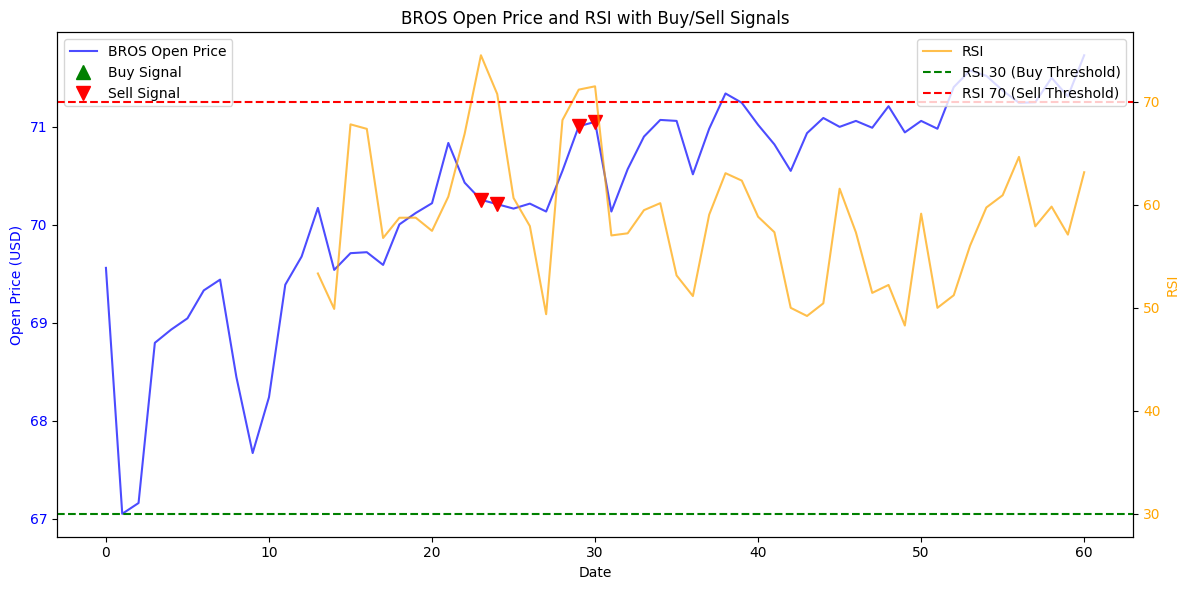

         Open        RSI Signal
56  71.245003  64.657705   Hold
57  71.250000  57.911579   Hold
58  71.500000  59.828594   Hold
59  71.309998  57.109587   Hold
60  71.730003  63.166385   Hold


In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(BROS_data.index, BROS_data['Open'], label="BROS Open Price", color='blue', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Open Price (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1.plot(BROS_data.index[BROS_data['Buy_Signal']], BROS_data['Open'][BROS_data['Buy_Signal']], '^', markersize=10, color='green', label='Buy Signal')
ax1.plot(BROS_data.index[BROS_data['Sell_Signal']], BROS_data['Open'][BROS_data['Sell_Signal']], 'v', markersize=10, color='red', label='Sell Signal')

ax2 = ax1.twinx()
ax2.plot(BROS_data.index, BROS_data['RSI'], label="RSI", color='orange', alpha=0.7)
ax2.axhline(y=30, color='green', linestyle='--', label='RSI 30 (Buy Threshold)')
ax2.axhline(y=70, color='red', linestyle='--', label='RSI 70 (Sell Threshold)')
ax2.set_ylabel('RSI', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("BROS Open Price and RSI with Buy/Sell Signals")
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

print(BROS_data[['Open', 'RSI', 'Signal']].tail())

In [ ]:
BROS = yf.Ticker("BROS")
BROS_data = BROS.history(start="2025-08-07", end="2025-08-08", interval = '1m')
BROS_data = BROS_data.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
BROS_data.drop('Volume', axis = 1, inplace=True)

BROS_data.index = BROS_data.index.tz_convert('US/Eastern')

BROS_data = BROS_data[BROS_data.Open != BROS_data.Close]

start_time = pd.Timestamp("2025-08-07 09:30:00", tz="US/Eastern")
end_time = pd.Timestamp("2025-08-07 10:30:00", tz="US/Eastern")
BROS_data = BROS_data[(BROS_data.index >= start_time) & (BROS_data.index <= end_time)]

BROS_data = BROS_data.reset_index()

def moving_average_filter(data, window_size):
    window = np.ones(window_size) / float(window_size)
    convolved_data = np.convolve(data, window, 'same')
    print("Original data: {}".format(data[:10]))
    print("Moving average filtered data with window size {}: {}".format(window_size, convolved_data[:10]))
    return convolved_data

window_size = 4

open_prices = BROS_data['Open'].values
denoised_open = moving_average_filter(open_prices, window_size)
BROS_data['Denoised_Open'] = denoised_open
print(BROS_data[['Datetime', 'Open', 'Denoised_Open']].head(10))

change_BROS = BROS_data['Denoised_Open'].diff()
gain_BROS = change_BROS.where(change_BROS > 0, 0)
loss_BROS = -change_BROS.where(change_BROS < 0, 0)
avg_gain_BROS  = gain_BROS.rolling(window=14).mean()
avg_loss_BROS = loss_BROS.rolling(window=14).mean()

rsi_BROS = avg_gain_BROS / (avg_loss_BROS + 1e-10)

BROS_data['RSI'] = 100 - (100 / (1 + rsi_BROS))

buy_threshold = 30
sell_threshold = 70

BROS_data['Buy_Signal'] = (BROS_data['RSI'] < buy_threshold)
BROS_data['Sell_Signal'] = (BROS_data['RSI'] > sell_threshold)

BROS_data['Signal'] = 'Hold'
BROS_data.loc[BROS_data['Buy_Signal'], 'Signal'] = 'Buy'
BROS_data.loc[BROS_data['Sell_Signal'], 'Signal'] = 'Sell'

Original data: [69.55999756 67.05000305 67.16000366 68.79499817 68.93000031 69.04499817
 69.33000183 69.44000244 68.44629669 67.66999817]
Moving average filtered data with window size 4: [34.15250015 50.94250107 68.14125061 67.9837513  68.48250008 69.02499962
 69.18625069 69.06532478 68.72157478 68.44907379]
                   Datetime       Open  Denoised_Open
0 2025-08-07 09:30:00-04:00  69.559998      34.152500
1 2025-08-07 09:31:00-04:00  67.050003      50.942501
2 2025-08-07 09:32:00-04:00  67.160004      68.141251
3 2025-08-07 09:33:00-04:00  68.794998      67.983751
4 2025-08-07 09:34:00-04:00  68.930000      68.482500
5 2025-08-07 09:35:00-04:00  69.044998      69.025000
6 2025-08-07 09:36:00-04:00  69.330002      69.186251
7 2025-08-07 09:37:00-04:00  69.440002      69.065325
8 2025-08-07 09:38:00-04:00  68.446297      68.721575
9 2025-08-07 09:39:00-04:00  67.669998      68.449074


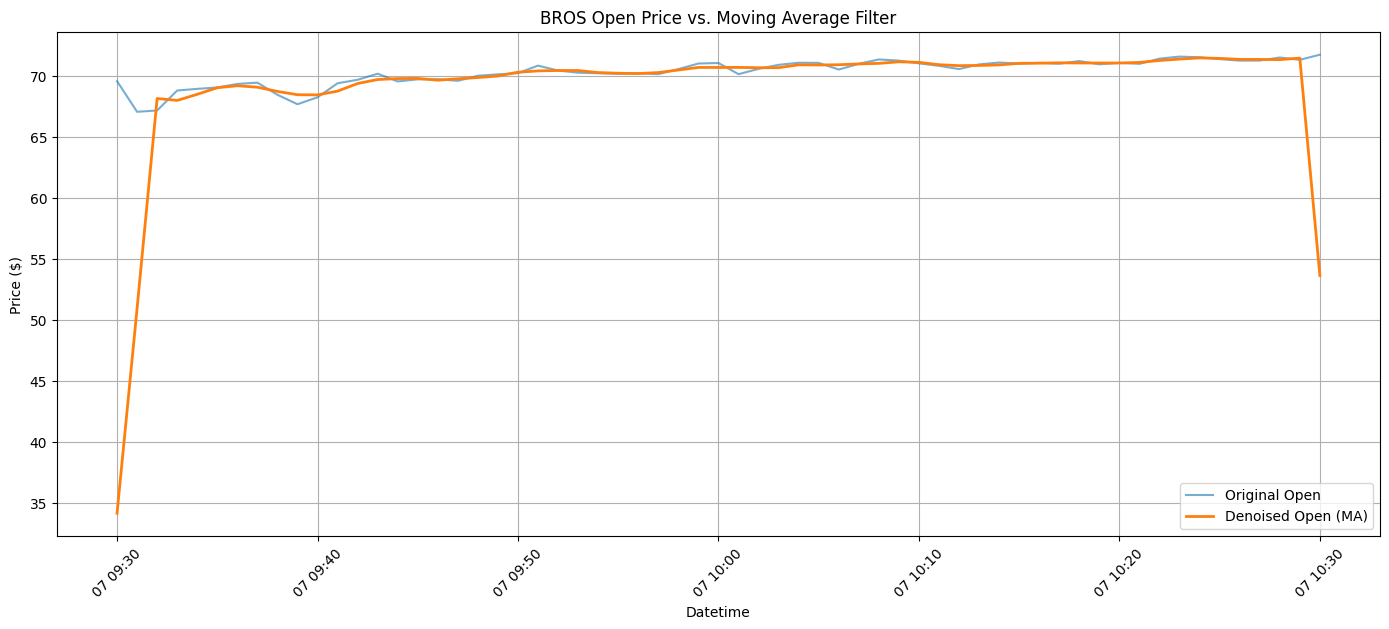

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(BROS_data['Datetime'], BROS_data['Open'], label='Original Open', alpha=0.6)
plt.plot(BROS_data['Datetime'], BROS_data['Denoised_Open'], label='Denoised Open (MA)', linewidth=2)

plt.title('BROS Open Price vs. Moving Average Filter')
plt.xlabel('Datetime')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [ ]:
gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.15,
                                 random_state=40, max_features=2)
gbc.fit(X_train_2d, y_train)
gbc_proba = gbc.predict_proba(X_test_2d)[:, 1]
gbc_preds = gbc.predict(X_test_2d)
gbc_acc = accuracy_score(y_test, gbc_preds)
print("Gradient Boosting Accuracy:", gbc_acc)


Gradient Boosting Accuracy: 0.5


In [ ]:
rf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=30)
rf.fit(X_train_2d, y_train)
rf_proba = rf.predict_proba(X_test_2d)[:, 1]
rf_preds = rf.predict(X_test_2d)
rf_acc = accuracy_score(y_test, rf_preds)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 0.5


In [ ]:
Open_df = pd.DataFrame({'Denoised_Open': Open})
Open_df['Shift1'] = Open_df['Denoised_Open'].shift(1)
Open_df['Shift2'] = Open_df['Denoised_Open'].shift(2)
Open_df['Shift3'] = Open_df['Denoised_Open'].shift(3)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_3d, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_proba = model.predict(X_test_3d).ravel()
lstm_acc = model.evaluate(X_test_3d, y_test, verbose=0)[1]
print("LSTM Accuracy:", lstm_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
LSTM Accuracy: 0.5


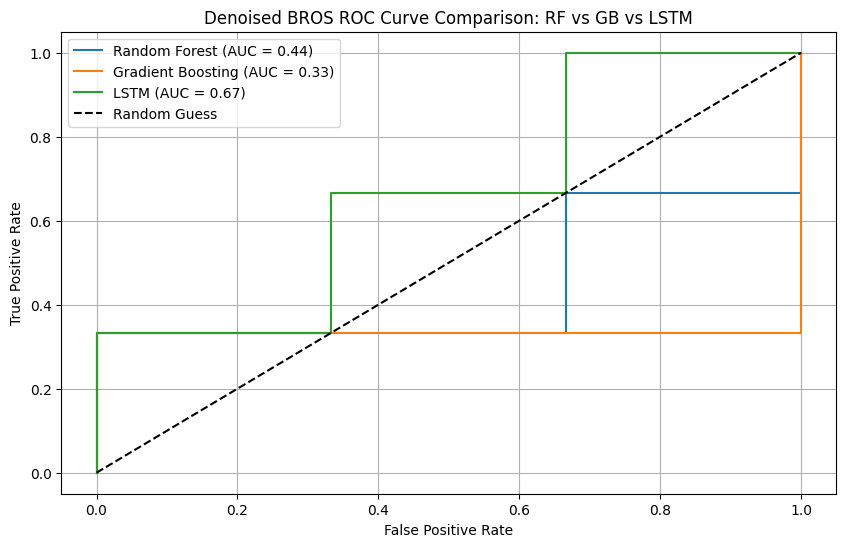

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, gbc_proba)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_proba)

auc_rf = auc(fpr_rf, tpr_rf)
auc_gbc = auc(fpr_gbc, tpr_gbc)
auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_gbc, tpr_gbc, label=f'Gradient Boosting (AUC = {auc_gbc:.2f})')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Denoised BROS ROC Curve Comparison: RF vs GB vs LSTM')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
change_BROS = BROS_data['Denoised_Open'].diff()
gain_BROS = change_BROS.where(change_BROS > 0, 0)
loss_BROS = -change_BROS.where(change_BROS < 0, 0)
avg_gain_BROS  = gain_BROS.rolling(window=14).mean()
avg_loss_BROS = loss_BROS.rolling(window=14).mean()

rsi_BROS = avg_gain_BROS / (avg_loss_BROS + 1e-10)

BROS_data['RSI'] = 100 - (100 / (1 + rsi_BROS))

BROS_data.replace([np.inf, -np.inf], np.nan, inplace=True)
BROS_data.dropna(inplace=True)

full_df_cleaned = BROS_data[['Denoised_Open']].copy()
full_df_cleaned['Shift1'] = full_df_cleaned['Denoised_Open'].shift(1)
full_df_cleaned['Shift2'] = full_df_cleaned['Denoised_Open'].shift(2)
full_df_cleaned['Shift3'] = full_df_cleaned['Denoised_Open'].shift(3)
full_df_cleaned['Target'] = (full_df_cleaned['Denoised_Open'].shift(-1) > full_df_cleaned['Denoised_Open']).astype(int)
full_df_cleaned.dropna(inplace=True)

total_size_cleaned = len(full_df_cleaned)
train_end_cleaned = int(0.7 * total_size_cleaned)
val_end_cleaned = int(0.9 * total_size_cleaned)

train_df_cleaned = full_df_cleaned.iloc[:train_end_cleaned]
test_df_cleaned  = full_df_cleaned.iloc[val_end_cleaned:]

X_train_cleaned = train_df_cleaned[['Shift1', 'Shift2', 'Shift3']]
y_train_cleaned = train_df_cleaned['Target']
X_test_cleaned   = test_df_cleaned[['Shift1', 'Shift2', 'Shift3']]
y_test_cleaned   = test_df_cleaned['Target']


X_train_cleaned['RSI'] = BROS_data.loc[X_train_cleaned.index, 'RSI']
X_test_cleaned['RSI'] = BROS_data.loc[X_test_cleaned.index, 'RSI']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_cleaned)
X_test_scaled = scaler.transform(X_test_cleaned)

X_train_2d = pd.DataFrame(X_train_scaled, columns=X_train_cleaned.columns)
X_test_2d = pd.DataFrame(X_test_scaled, columns=X_test_cleaned.columns)


gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.07, random_state=40, max_features=2)
gbc.fit(X_train_scaled, y_train_cleaned)

BROS_gbc_proba_rsi = gbc.predict_proba(X_test_scaled)[:, 1]
BROS_gbc_preds_rsi = gbc.predict(X_test_scaled)
BROS_gbc_acc_rsi = accuracy_score(y_test_cleaned, BROS_gbc_preds_rsi)

print("BROS Gradient Boosting Accuracy with RSI:", BROS_gbc_acc_rsi)


/tmp/ipython-input-2883701854.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_cleaned['RSI'] = BROS_data.loc[X_train_cleaned.index, 'RSI']
/tmp/ipython-input-2883701854.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_cleaned['RSI'] = BROS_data.loc[X_test_cleaned.index, 'RSI']


BROS Gradient Boosting Accuracy with RSI: 0.6


In [ ]:
BROS_Money = Money('1000000.00', 'USD')
Initial_Investment = BROS_Money.amount
Shares = 0
Portfolio_value = Initial_Investment
buy_threshold = 30
sell_threshold = 70
Trade_log = []

BROS_data['Buy_Signal'] = (BROS_data['RSI'] < buy_threshold)
BROS_data['Sell_Signal'] = (BROS_data['RSI'] > sell_threshold)

BROS_data['Signal'] = 'Hold'
BROS_data.loc[BROS_data['Buy_Signal'], 'Signal'] = 'Buy'
BROS_data.loc[BROS_data['Sell_Signal'], 'Signal'] = 'Sell'

for i in range(1, len(BROS_data)):
    current_date = BROS_data.index[i]
    current_rsi = BROS_data['RSI'].iloc[i]
    current_open = BROS_data['Denoised_Open'].iloc[i]
    current_open_decimal = Decimal(str(current_open))

    if current_rsi < buy_threshold and BROS_Money.amount >= current_open_decimal:
        num_shares_to_buy = int(BROS_Money.amount // current_open_decimal)
        if num_shares_to_buy > 0:
            new_amount = BROS_Money.amount - (num_shares_to_buy * current_open_decimal)
            BROS_Money = Money(str(new_amount), 'USD')
            Shares += num_shares_to_buy
            Trade_log.append(f"{current_date}: Bought {num_shares_to_buy} shares at {current_open_decimal:.2f} USD")

    elif current_rsi > sell_threshold and Shares > 0:
        new_amount = BROS_Money.amount + (Shares * current_open_decimal)
        BROS_Money = Money(str(new_amount), 'USD')
        Trade_log.append(f"{current_date}: Sold {Shares} shares at {current_open_decimal:.2f} USD")
        Shares = 0

    Portfolio_value = BROS_Money.amount + (Shares * current_open_decimal)



final_value = Portfolio_value
total_return = final_value - Initial_Investment
total_percentage_return = (total_return / Initial_Investment) * 100

print(f"Final Portfolio Value: {final_value:,.2f} USD")
print(f"Total Return: {total_return:,.2f} USD")
print(f"Total Percentage Return: {total_percentage_return:.2f}%")

for trade in Trade_log:
    print(trade)



Final Portfolio Value: 1,000,000.00 USD
Total Return: 0.00 USD
Total Percentage Return: 0.00%
60: Bought 18644 shares at 53.64 USD


# IBP Stock Test

In [ ]:
IBP = yf.Ticker("IBP")
IBP_data = IBP.history(start="2025-08-07", end="2025-08-08", interval = '1m')
IBP_data = IBP_data.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
IBP_data.drop('Volume', axis = 1, inplace=True)

IBP_data.index = IBP_data.index.tz_convert('US/Eastern')

IBP_data = IBP_data[IBP_data.Open != IBP_data.Close]

start_time = pd.Timestamp("2025-08-07 09:30:00", tz="US/Eastern")
end_time = pd.Timestamp("2025-08-07 12:30:00", tz="US/Eastern")
IBP_data = IBP_data[(IBP_data.index >= start_time) & (IBP_data.index <= end_time)]

IBP_data = IBP_data.reset_index()

IBP_data.head(10)
IBP_data.tail(10)

,Datetime,Open,High,Low,Close,Dividends,Stock Splits
143,2025-08-07 12:18:00-04:00,261.230011,262.470001,261.230011,262.339600,0.0,0.0
144,2025-08-07 12:19:00-04:00,261.880005,262.769470,261.880005,262.769470,0.0,0.0
145,2025-08-07 12:20:00-04:00,262.229492,262.410004,261.720001,262.279999,0.0,0.0
146,2025-08-07 12:22:00-04:00,262.109985,262.269989,262.100006,262.179993,0.0,0.0
147,2025-08-07 12:23:00-04:00,262.184998,262.570007,262.184998,262.200012,0.0,0.0
148,2025-08-07 12:24:00-04:00,262.459991,262.839996,262.420013,262.424988,0.0,0.0
149,2025-08-07 12:25:00-04:00,262.437500,263.195007,262.424988,263.100006,0.0,0.0
150,2025-08-07 12:26:00-04:00,262.369995,262.959991,262.209991,262.959991,0.0,0.0
151,2025-08-07 12:27:00-04:00,262.964996,262.964996,261.709991,261.709991,0.0,0.0
152,2025-08-07 12:30:00-04:00,262.040009,262.040009,261.359985,261.359985,0.0,0.0


In [ ]:
Open = IBP_data["Open"].reset_index(drop=True)
total_size = len(Open)

train_end = int(0.7 * total_size)
val_end = int(0.9 * total_size)

train = Open.iloc[:train_end]
valid = Open.iloc[train_end:val_end]
test = Open.iloc[val_end:]

def create_features_targets(open_series):
    df = pd.DataFrame({'Open': open_series})
    df['Shift1'] = df['Open'].shift(1)
    df['Shift2'] = df['Open'].shift(2)
    df['Shift3'] = df['Open'].shift(3)
    df['Target'] = (df['Open'].shift(-1) > df['Open']).astype(int)
    df.dropna(inplace=True)
    return df[['Shift1', 'Shift2', 'Shift3']], df['Target']

full_df = pd.DataFrame({'Open': Open})
full_df['Shift1'] = full_df['Open'].shift(1)
full_df['Shift2'] = full_df['Open'].shift(2)
full_df['Shift3'] = full_df['Open'].shift(3)
full_df['Target'] = (full_df['Open'].shift(-1) > full_df['Open']).astype(int)
full_df.dropna(inplace=True)

full_df.reset_index(drop=True, inplace=True)

total_size = len(full_df)
train_end = int(0.7 * total_size)
val_end = int(0.9 * total_size)

train_df = full_df.iloc[:train_end]
valid_df = full_df.iloc[train_end:val_end]
test_df  = full_df.iloc[val_end:]

X_train, y_train = train_df[['Shift1', 'Shift2', 'Shift3']], train_df['Target']
X_valid, y_valid = valid_df[['Shift1', 'Shift2', 'Shift3']], valid_df['Target']
X_test, y_test   = test_df[['Shift1', 'Shift2', 'Shift3']], test_df['Target']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)
X_train_2d, X_test_2d = X_train_scaled.copy(), X_test_scaled.copy()
X_train_3d = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_3d  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.15,
                                 random_state=40, max_features=2)
gbc.fit(X_train_2d, y_train)
gbc_proba = gbc.predict_proba(X_test_2d)[:, 1]
gbc_preds = gbc.predict(X_test_2d)
gbc_acc = accuracy_score(y_test, gbc_preds)
print("Gradient Boosting Accuracy:", gbc_acc)

rf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=30)
rf.fit(X_train_2d, y_train)
rf_proba = rf.predict_proba(X_test_2d)[:, 1]
rf_preds = rf.predict(X_test_2d)
rf_acc = accuracy_score(y_test, rf_preds)
print("Random Forest Accuracy:", rf_acc)

Open_df = pd.DataFrame({'Open': Open})
Open_df['Shift1'] = Open_df['Open'].shift(1)
Open_df['Shift2'] = Open_df['Open'].shift(2)
Open_df['Shift3'] = Open_df['Open'].shift(3)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_3d, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_proba = model.predict(X_test_3d).ravel()
lstm_acc = model.evaluate(X_test_3d, y_test, verbose=0)[1]
print("LSTM Accuracy:", lstm_acc)

Gradient Boosting Accuracy: 0.4666666666666667
Random Forest Accuracy: 0.4666666666666667


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
LSTM Accuracy: 0.46666666865348816


In [ ]:
change_IBP = IBP_data['Open'].diff()
gain_IBP = change_IBP.where(change_IBP > 0, 0)
loss_IBP = -change_IBP.where(change_IBP < 0, 0)
avg_gain_IBP  = gain_IBP.rolling(window=14).mean()
avg_loss_IBP = loss_IBP.rolling(window=14).mean()
rsi_IBP = avg_gain_IBP / avg_loss_IBP
IBP_data['RSI'] = 100 - (100 / (1 + rsi_IBP))
rsi_IBP.dropna(inplace=True)
rsi_IBP.head()

X_train_2d = pd.DataFrame(X_train_2d)
X_test_2d = pd.DataFrame(X_test_2d)
X_train_2d.columns = X_train_2d.columns.astype(str)
X_test_2d.columns = X_test_2d.columns.astype(str)
X_train_2d['RSI'] = rsi_IBP.iloc[:len(X_train_2d)].values
X_test_2d['RSI'] = rsi_IBP.iloc[len(X_train_2d):len(X_train_2d)+len(X_test_2d)].values
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.07, random_state=40, max_features=2)
gbc.fit(X_train_scaled, y_train)

IBP_gbc_proba_rsi = gbc.predict_proba(X_test_scaled)[:, 1]
IBP_gbc_preds_rsi = gbc.predict(X_test_scaled)
IBP_gbc_acc_rsi = accuracy_score(y_test, IBP_gbc_preds_rsi)

print("IBP Gradient Boosting Accuracy with RSI:", IBP_gbc_acc_rsi)
print("IBP Gradient Boosting Accuracy without RSI", gbc_acc)


IBP Gradient Boosting Accuracy with RSI: 0.4666666666666667
IBP Gradient Boosting Accuracy without RSI 0.4666666666666667


In [ ]:
IBP_Money = Money('1000000.00', 'USD')
Initial_Investment = IBP_Money.amount
Shares = 0
Portfolio_value = Initial_Investment
buy_threshold = 30
sell_threshold = 70
Trade_log = []

IBP_data['Buy_Signal'] = (IBP_data['RSI'] < buy_threshold)
IBP_data['Sell_Signal'] = (IBP_data['RSI'] > sell_threshold)

IBP_data['Signal'] = 'Hold'
IBP_data.loc[IBP_data['Buy_Signal'], 'Signal'] = 'Buy'
IBP_data.loc[IBP_data['Sell_Signal'], 'Signal'] = 'Sell'

for i in range(1, len(IBP_data)):
    current_date = IBP_data.index[i]
    current_rsi = IBP_data['RSI'].iloc[i]
    current_open = IBP_data['Open'].iloc[i]
    current_open_decimal = Decimal(str(current_open))

    if current_rsi < buy_threshold and IBP_Money.amount >= current_open_decimal:
        num_shares_to_buy = int(IBP_Money.amount // current_open_decimal)
        if num_shares_to_buy > 0:
            new_amount = IBP_Money.amount - (num_shares_to_buy * current_open_decimal)
            IBP_Money = Money(str(new_amount), 'USD')
            Shares += num_shares_to_buy
            Trade_log.append(f"{current_date}: Bought {num_shares_to_buy} shares at {current_open_decimal:.2f} USD")

    elif current_rsi > sell_threshold and Shares > 0:
        new_amount = IBP_Money.amount + (Shares * current_open_decimal)
        IBP_Money = Money(str(new_amount), 'USD')
        Trade_log.append(f"{current_date}: Sold {Shares} shares at {current_open_decimal:.2f} USD")
        Shares = 0

    Portfolio_value = IBP_Money.amount + (Shares * current_open_decimal)



final_value = Portfolio_value
total_return = final_value - Initial_Investment
total_percentage_return = (total_return / Initial_Investment) * 100

print(f"Final Portfolio Value: {final_value:,.2f} USD")
print(f"Total Return: {total_return:,.2f} USD")
print(f"Total Percentage Return: {total_percentage_return:.2f}%")

for trade in Trade_log:
    print(trade)



Final Portfolio Value: 1,000,000.00 USD
Total Return: 0.00 USD
Total Percentage Return: 0.00%


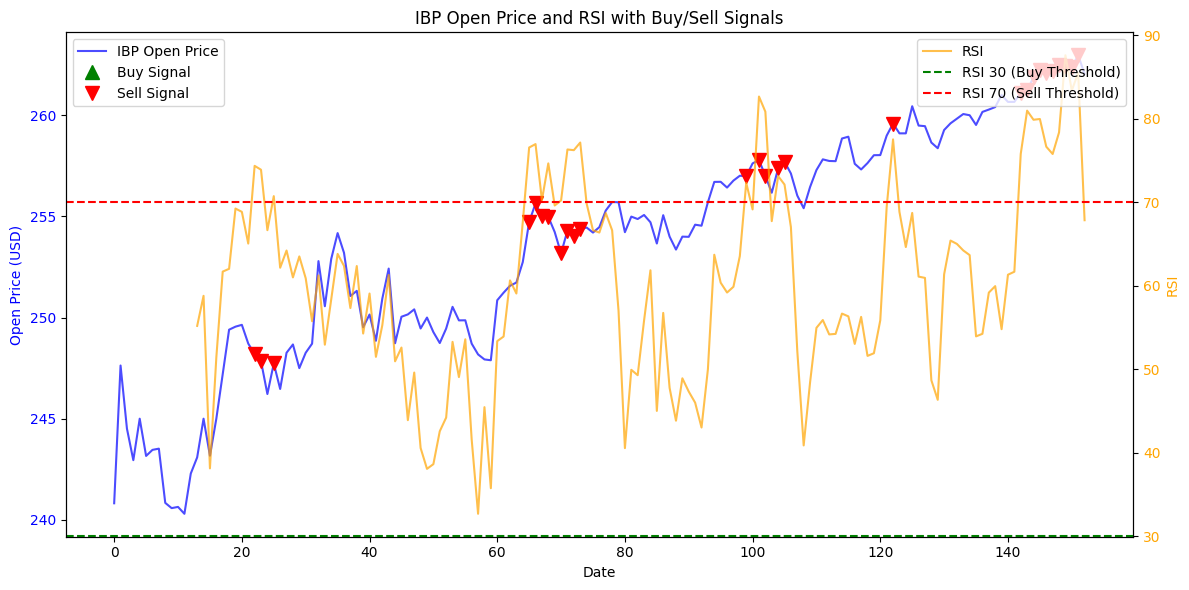

           Open        RSI Signal
148  262.459991  78.347318   Sell
149  262.437500  87.582259   Sell
150  262.369995  83.368586   Sell
151  262.964996  85.478330   Sell
152  262.040009  67.838219   Hold


In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(IBP_data.index, IBP_data['Open'], label="IBP Open Price", color='blue', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Open Price (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1.plot(IBP_data.index[IBP_data['Buy_Signal']], IBP_data['Open'][IBP_data['Buy_Signal']], '^', markersize=10, color='green', label='Buy Signal')
ax1.plot(IBP_data.index[IBP_data['Sell_Signal']], IBP_data['Open'][IBP_data['Sell_Signal']], 'v', markersize=10, color='red', label='Sell Signal')

ax2 = ax1.twinx()
ax2.plot(IBP_data.index, IBP_data['RSI'], label="RSI", color='orange', alpha=0.7)
ax2.axhline(y=30, color='green', linestyle='--', label='RSI 30 (Buy Threshold)')
ax2.axhline(y=70, color='red', linestyle='--', label='RSI 70 (Sell Threshold)')
ax2.set_ylabel('RSI', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("IBP Open Price and RSI with Buy/Sell Signals")
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

print(IBP_data[['Open', 'RSI', 'Signal']].tail())

In [ ]:
IBP = yf.Ticker("IBP")
IBP_data = IBP.history(start="2025-08-07", end="2025-08-08", interval = '1m')
IBP_data = IBP_data.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
IBP_data.drop('Volume', axis = 1, inplace=True)

IBP_data.index = IBP_data.index.tz_convert('US/Eastern')

IBP_data = IBP_data[IBP_data.Open != IBP_data.Close]

start_time = pd.Timestamp("2025-08-07 09:30:00", tz="US/Eastern")
end_time = pd.Timestamp("2025-08-07 12:30:00", tz="US/Eastern")
IBP_data = IBP_data[(IBP_data.index >= start_time) & (IBP_data.index <= end_time)]

IBP_data = IBP_data.reset_index()

def moving_average_filter(data, window_size):
    window = np.ones(window_size) / float(window_size)
    convolved_data = np.convolve(data, window, 'same')
    print("Original data: {}".format(data[:10]))
    print("Moving average filtered data with window size {}: {}".format(window_size, convolved_data[:10]))
    return convolved_data

window_size = 4

open_prices = IBP_data['Open'].values
denoised_open = moving_average_filter(open_prices, window_size)
IBP_data['Denoised_Open'] = denoised_open
print(IBP_data[['Datetime', 'Open', 'Denoised_Open']].head(10))

change_IBP = IBP_data['Denoised_Open'].diff()
gain_IBP = change_IBP.where(change_IBP > 0, 0)
loss_IBP = -change_IBP.where(change_IBP < 0, 0)
avg_gain_IBP  = gain_IBP.rolling(window=14).mean()
avg_loss_IBP = loss_IBP.rolling(window=14).mean()

rsi_IBP = avg_gain_IBP / (avg_loss_IBP + 1e-10)

IBP_data['RSI'] = 100 - (100 / (1 + rsi_IBP))

buy_threshold = 30
sell_threshold = 70

IBP_data['Buy_Signal'] = (IBP_data['RSI'] < buy_threshold)
IBP_data['Sell_Signal'] = (IBP_data['RSI'] > sell_threshold)

IBP_data['Signal'] = 'Hold'
IBP_data.loc[IBP_data['Buy_Signal'], 'Signal'] = 'Buy'
IBP_data.loc[IBP_data['Sell_Signal'], 'Signal'] = 'Sell'




Original data: [240.82000732 247.63000488 244.50999451 242.94999695 245.
 243.16000366 243.46000671 243.52000427 240.83999634 240.58000183]
Moving average filtered data with window size 4: [122.11250305 183.24000168 243.97750092 245.02249908 243.90499878
 243.64250183 243.78500366 242.74500275 242.10000229 241.39500046]
                   Datetime        Open  Denoised_Open
0 2025-08-07 09:32:00-04:00  240.820007     122.112503
1 2025-08-07 09:33:00-04:00  247.630005     183.240002
2 2025-08-07 09:35:00-04:00  244.509995     243.977501
3 2025-08-07 09:36:00-04:00  242.949997     245.022499
4 2025-08-07 09:37:00-04:00  245.000000     243.904999
5 2025-08-07 09:38:00-04:00  243.160004     243.642502
6 2025-08-07 09:39:00-04:00  243.460007     243.785004
7 2025-08-07 09:40:00-04:00  243.520004     242.745003
8 2025-08-07 09:41:00-04:00  240.839996     242.100002
9 2025-08-07 09:42:00-04:00  240.580002     241.395000


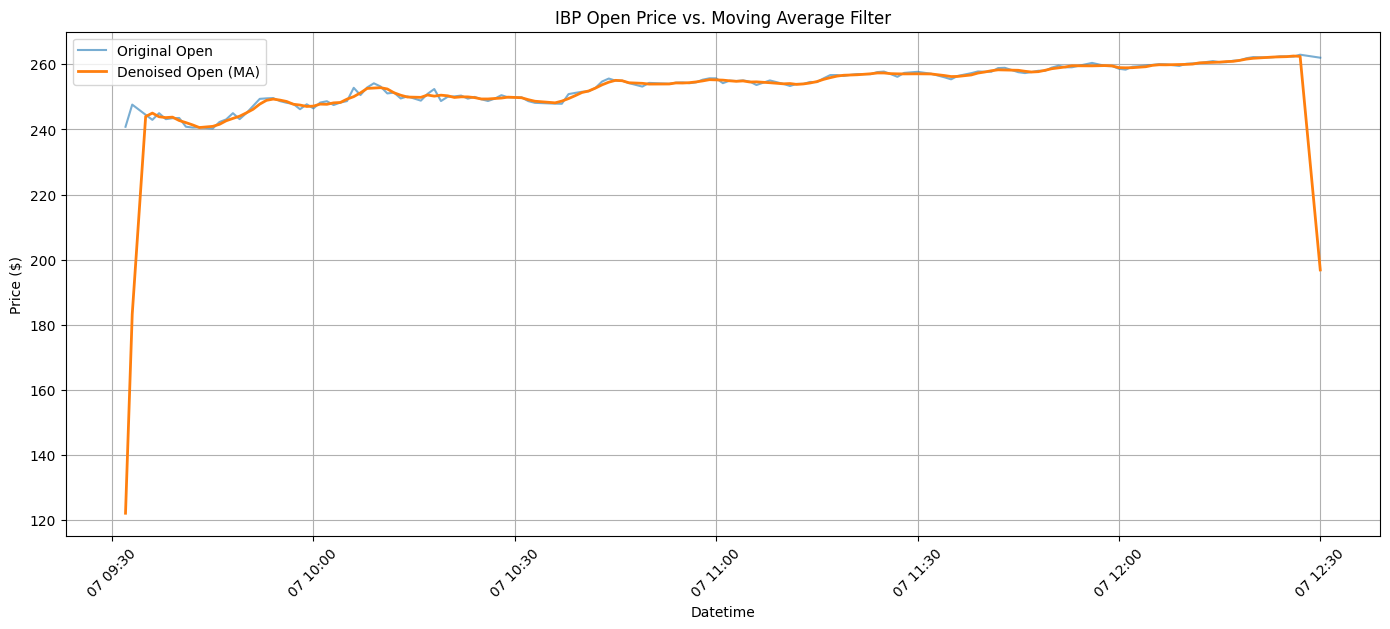

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(IBP_data['Datetime'], IBP_data['Open'], label='Original Open', alpha=0.6)
plt.plot(IBP_data['Datetime'], IBP_data['Denoised_Open'], label='Denoised Open (MA)', linewidth=2)

plt.title('IBP Open Price vs. Moving Average Filter')
plt.xlabel('Datetime')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [ ]:
gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.15,
                                 random_state=40, max_features=2)
gbc.fit(X_train_2d, y_train)
gbc_proba = gbc.predict_proba(X_test_2d)[:, 1]
gbc_preds = gbc.predict(X_test_2d)
gbc_acc = accuracy_score(y_test, gbc_preds)
print("Gradient Boosting Accuracy:", gbc_acc)


Gradient Boosting Accuracy: 0.4666666666666667


In [ ]:
rf = RandomForestClassifier(n_estimators=546, max_depth=10, random_state=30)
rf.fit(X_train_2d, y_train)
rf_proba = rf.predict_proba(X_test_2d)[:, 1]
rf_preds = rf.predict(X_test_2d)
rf_acc = accuracy_score(y_test, rf_preds)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 0.4666666666666667


In [ ]:
Open_df = pd.DataFrame({'Denoised_Open': Open})
Open_df['Shift1'] = Open_df['Denoised_Open'].shift(1)
Open_df['Shift2'] = Open_df['Denoised_Open'].shift(2)
Open_df['Shift3'] = Open_df['Denoised_Open'].shift(3)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_3d, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_proba = model.predict(X_test_3d).ravel()
lstm_acc = model.evaluate(X_test_3d, y_test, verbose=0)[1]
print("LSTM Accuracy:", lstm_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
LSTM Accuracy: 0.46666666865348816


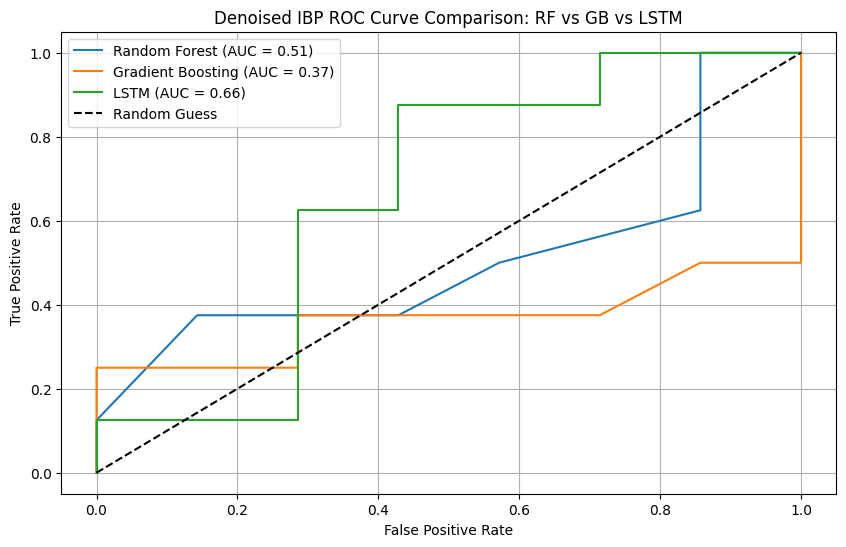

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, gbc_proba)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_proba)

auc_rf = auc(fpr_rf, tpr_rf)
auc_gbc = auc(fpr_gbc, tpr_gbc)
auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_gbc, tpr_gbc, label=f'Gradient Boosting (AUC = {auc_gbc:.2f})')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Denoised IBP ROC Curve Comparison: RF vs GB vs LSTM')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
change_IBP = IBP_data['Denoised_Open'].diff()
gain_IBP = change_IBP.where(change_IBP > 0, 0)
loss_IBP = -change_IBP.where(change_IBP < 0, 0)
avg_gain_IBP  = gain_IBP.rolling(window=14).mean()
avg_loss_IBP = loss_IBP.rolling(window=14).mean()

rsi_IBP = avg_gain_IBP / (avg_loss_IBP + 1e-10)

IBP_data['RSI'] = 100 - (100 / (1 + rsi_IBP))

IBP_data.replace([np.inf, -np.inf], np.nan, inplace=True)
IBP_data.dropna(inplace=True)

full_df_cleaned = IBP_data[['Denoised_Open']].copy()
full_df_cleaned['Shift1'] = full_df_cleaned['Denoised_Open'].shift(1)
full_df_cleaned['Shift2'] = full_df_cleaned['Denoised_Open'].shift(2)
full_df_cleaned['Shift3'] = full_df_cleaned['Denoised_Open'].shift(3)
full_df_cleaned['Target'] = (full_df_cleaned['Denoised_Open'].shift(-1) > full_df_cleaned['Denoised_Open']).astype(int)
full_df_cleaned.dropna(inplace=True)

total_size_cleaned = len(full_df_cleaned)
train_end_cleaned = int(0.7 * total_size_cleaned)
val_end_cleaned = int(0.9 * total_size_cleaned)

train_df_cleaned = full_df_cleaned.iloc[:train_end_cleaned]
test_df_cleaned  = full_df_cleaned.iloc[val_end_cleaned:]

X_train_cleaned = train_df_cleaned[['Shift1', 'Shift2', 'Shift3']]
y_train_cleaned = train_df_cleaned['Target']
X_test_cleaned   = test_df_cleaned[['Shift1', 'Shift2', 'Shift3']]
y_test_cleaned   = test_df_cleaned['Target']


X_train_cleaned['RSI'] = IBP_data.loc[X_train_cleaned.index, 'RSI']
X_test_cleaned['RSI'] = IBP_data.loc[X_test_cleaned.index, 'RSI']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_cleaned)
X_test_scaled = scaler.transform(X_test_cleaned)

X_train_2d = pd.DataFrame(X_train_scaled, columns=X_train_cleaned.columns)
X_test_2d = pd.DataFrame(X_test_scaled, columns=X_test_cleaned.columns)


gbc = GradientBoostingClassifier(n_estimators=546, learning_rate=0.07, random_state=40, max_features=2)
gbc.fit(X_train_scaled, y_train_cleaned)

IBP_gbc_proba_rsi = gbc.predict_proba(X_test_scaled)[:, 1]
IBP_gbc_preds_rsi = gbc.predict(X_test_scaled)
IBP_gbc_acc_rsi = accuracy_score(y_test_cleaned, IBP_gbc_preds_rsi)

print("IBP Gradient Boosting Accuracy with RSI:", IBP_gbc_acc_rsi)


/tmp/ipython-input-3625164396.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_cleaned['RSI'] = IBP_data.loc[X_train_cleaned.index, 'RSI']
/tmp/ipython-input-3625164396.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_cleaned['RSI'] = IBP_data.loc[X_test_cleaned.index, 'RSI']


IBP Gradient Boosting Accuracy with RSI: 0.21428571428571427


In [ ]:
IBP_Money = Money('1000000.00', 'USD')
Initial_Investment = IBP_Money.amount
Shares = 0
Portfolio_value = Initial_Investment
buy_threshold = 30
sell_threshold = 70
Trade_log = []

IBP_data['Buy_Signal'] = (IBP_data['RSI'] < buy_threshold)
IBP_data['Sell_Signal'] = (IBP_data['RSI'] > sell_threshold)

IBP_data['Signal'] = 'Hold'
IBP_data.loc[IBP_data['Buy_Signal'], 'Signal'] = 'Buy'
IBP_data.loc[IBP_data['Sell_Signal'], 'Signal'] = 'Sell'

for i in range(1, len(IBP_data)):
    current_date = IBP_data.index[i]
    current_rsi = IBP_data['RSI'].iloc[i]
    current_open = IBP_data['Denoised_Open'].iloc[i]
    current_open_decimal = Decimal(str(current_open))

    if current_rsi < buy_threshold and IBP_Money.amount >= current_open_decimal:
        num_shares_to_buy = int(IBP_Money.amount // current_open_decimal)
        if num_shares_to_buy > 0:
            new_amount = IBP_Money.amount - (num_shares_to_buy * current_open_decimal)
            IBP_Money = Money(str(new_amount), 'USD')
            Shares += num_shares_to_buy
            Trade_log.append(f"{current_date}: Bought {num_shares_to_buy} shares at {current_open_decimal:.2f} USD")

    elif current_rsi > sell_threshold and Shares > 0:
        new_amount = IBP_Money.amount + (Shares * current_open_decimal)
        IBP_Money = Money(str(new_amount), 'USD')
        Trade_log.append(f"{current_date}: Sold {Shares} shares at {current_open_decimal:.2f} USD")
        Shares = 0

    Portfolio_value = IBP_Money.amount + (Shares * current_open_decimal)



final_value = Portfolio_value
total_return = final_value - Initial_Investment
total_percentage_return = (total_return / Initial_Investment) * 100

print(f"Final Portfolio Value: {final_value:,.2f} USD")
print(f"Total Return: {total_return:,.2f} USD")
print(f"Total Percentage Return: {total_percentage_return:.2f}%")

for trade in Trade_log:
    print(trade)



Final Portfolio Value: 1,010,742.61 USD
Total Return: 10,742.61 USD
Total Percentage Return: 1.07%
48: Bought 3999 shares at 250.01 USD
64: Sold 3999 shares at 252.69 USD
152: Bought 5134 shares at 196.84 USD
